# DM-26087 Estimate the matching kernel size and test runs

 * Experiment with a test code to see whether the matching kernel is actually contained in image space by summing it up to a threshold close to its total sum. This does not really work for the matching kernel that has patterns all around. The problem of not having an effective size for the matching kernels complicates the mask propagation and also prevents the matching kernel convolution in image space.
 * Several scenario test run and plot of the ZOGY matching kernels, difference image PSF, matching kernel for the score image (sc1) This was the first evidence that the patterns are independent of how much padding we add, they always fill up all the space. Tested Gaussian generation routines in scipy for consistency, etc. A cavity of these scenarios, that only c1 is visualized, since then we are aware of that c1 and c2 behave differently.
 * Tries to make cuts to the FFTd PSF but this did not really help, only gave nice results in certain cases. A caveat of these scenarios, that only c1 is visualized.

In [2]:
%matplotlib notebook
import os.path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats
from lsst.ip.diffim.zogy import ZogyTask
from lsst.utils import getPackageDir
zogyTestFileName = os.path.join(getPackageDir('ip_diffim'),"tests/test_zogy.py")
%run -n -i $zogyTestFileName
%run -n -i "zogy_calculate_Pd_c1_sc1_c2.py"

In [4]:
# Experimental functions to estimate the size of a PSF 
# by summing it up from its center (peak)
def estimateCornerContainerSize(A, p=0.99):
    """Starting from the position 0, collapse the array along each axis to 1D 
    and sum it until `p` threshold is reached.
    """
    #A = np.abs(A)
    sA = np.sum(A, axis=1)
    csumy = np.cumsum(sA)
    thresh = csumy[-1] * p
    iy = np.searchsorted(csumy, thresh)
    sA = np.sum(A, axis=0)
    csumx = np.cumsum(sA)
    ix = np.searchsorted(csumx, thresh)
    return iy, ix

def estimateFourCornerSize(D, p):
    """Do the radius estimation for all four corners."""
    halfH = D.shape[0] // 2
    halfW = D.shape[1] // 2
    iy = np.zeros(4,dtype=int)
    ix = np.zeros(4,dtype=int)
    iy[0], ix[0] = estimateCornerContainerSize(D[0:halfH, 0:halfW], p)
    iy[1], ix[1] = estimateCornerContainerSize(D[-1:halfH-1:-1, 0:halfW], p)
    iy[2], ix[2] = estimateCornerContainerSize(D[-1:halfH-1:-1, -1:halfW-1:-1], p)
    iy[3], ix[3] = estimateCornerContainerSize(D[0:halfH, -1:halfW-1:-1], p)
    return iy, ix


In [5]:
# Psf1=3.3 psf2=2.2 sigma in pix.
im1ex, im2ex = makeFakeImages(size=(256, 256), svar=100., tvar=100.,
                              psf1=3.3, psf2=2.2,
                              n_sources=0, psf_yvary_factor=0, varSourceChange=0.1,
                              seed=1, verbose=False)
config = ZogyConfig()
config.scaleByCalibration = False
task = ZogyTask(config=config)
# res = task.run(im1ex, im2ex)

## Two Gaussians, different weights, different psfs, no extra smoothing

In [33]:
# Get the stack generated PSFs
A = im1ex.getPsf().computeImage().array
pA = task.padCenterOriginArray(A,(1024,1024))
# See our radius estimation for the input PSF
print(estimateFourCornerSize(pA,1. - 1e-4))
pA = np.fft.fft2(pA)
B = im2ex.getPsf().computeImage().array
pB = task.padCenterOriginArray(B,(1024,1024))
pB = np.fft.fft2(pB)

(array([12, 11, 11, 12]), array([12, 12, 11, 11]))


In [34]:
psf1 = pA
psf2 = pB
fPd, fc1, fsc1, _ = calculatePd(psf1,100,psf2,50)

Handling 0 both PSFs are zero points.


In [35]:
Pd = np.real(np.fft.ifft2(fPd))
c1 = np.real(np.fft.ifft2(fc1))
sc1 = np.real(np.fft.ifft2(fsc1))
Ps = np.real(np.fft.ifft2(np.conj(fPd)*fPd))

<IPython.core.display.Javascript object>


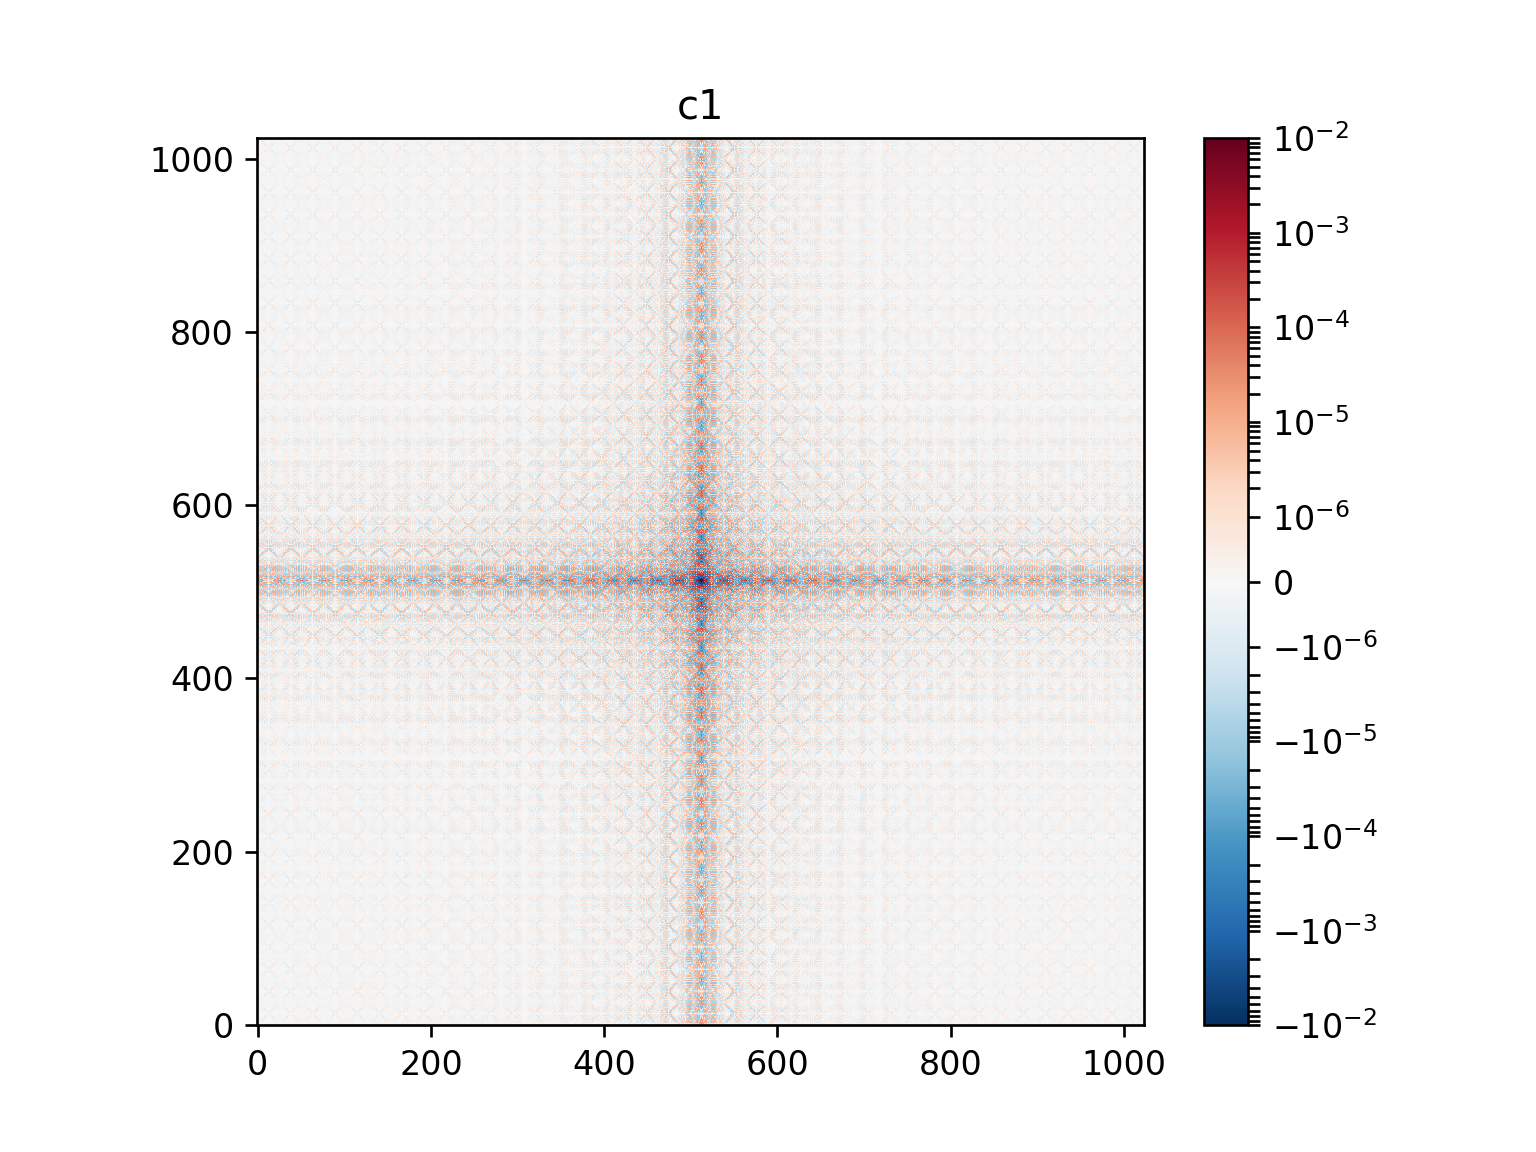

Text(0.5, 1.0, 'c1')

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(c1, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.01,vmax=0.01))
fig.colorbar(cs)
ax.set_title("c1")

In [14]:
fig.savefig("twoG_defaults_c1.pdf")

<IPython.core.display.Javascript object>


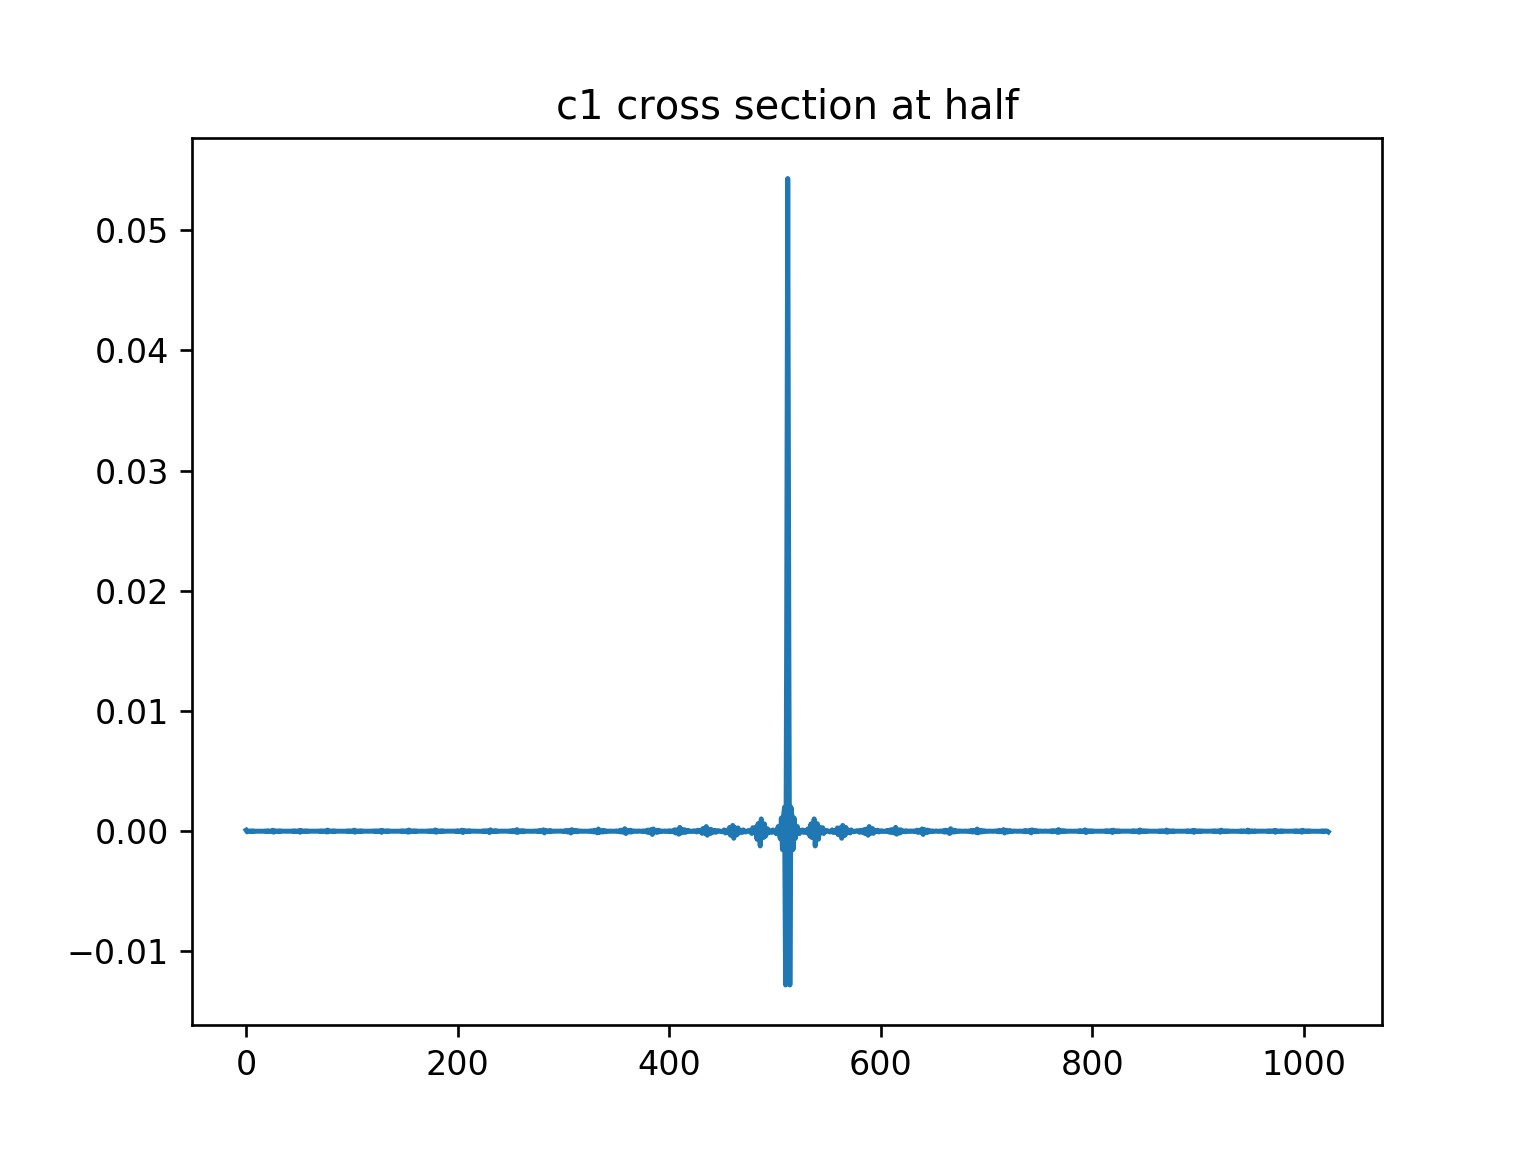

Text(0.5, 1.0, 'c1 cross section at half')

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(P2[512],'-')
ax.set_title("c1 cross section at half")

<IPython.core.display.Javascript object>


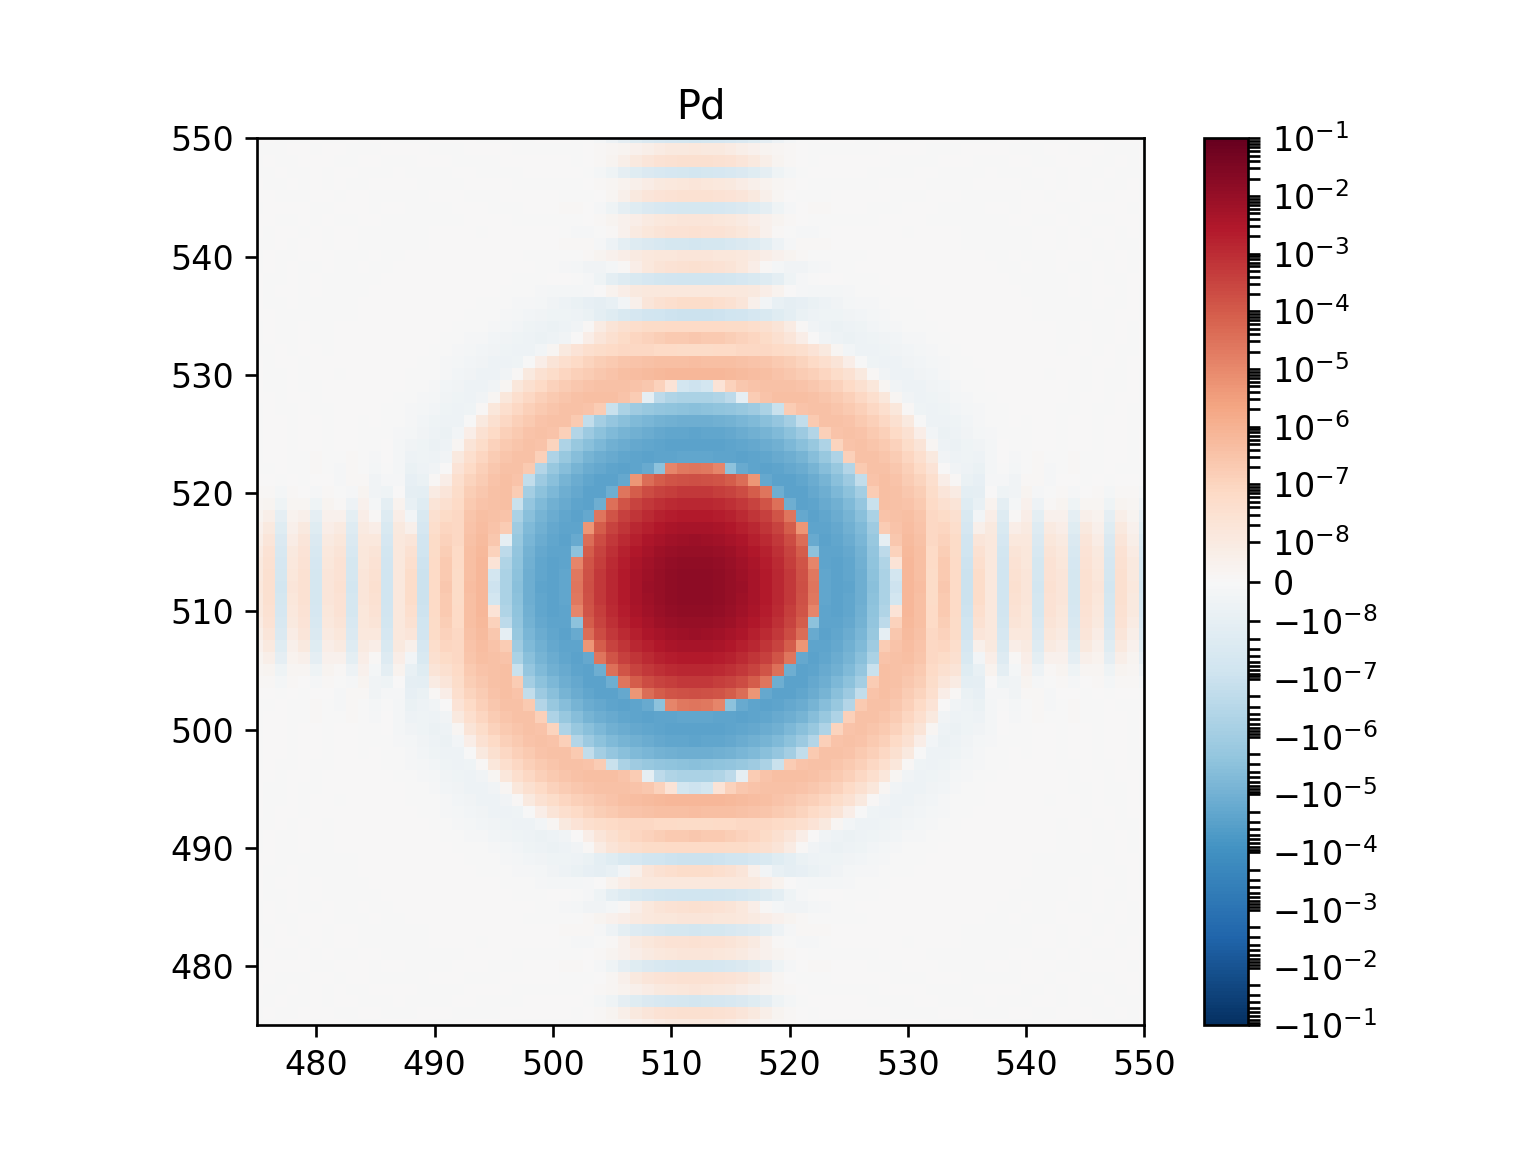

Text(0.5, 1.0, 'Pd')

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(Pd, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8,vmin=-0.1,vmax=0.1))
fig.colorbar(cs)
ax.set_ylim(475, 550)
ax.set_xlim(475, 550)
ax.set_title("Pd")

In [17]:
fig.savefig("twoG_defaults_Pd.pdf")

<IPython.core.display.Javascript object>


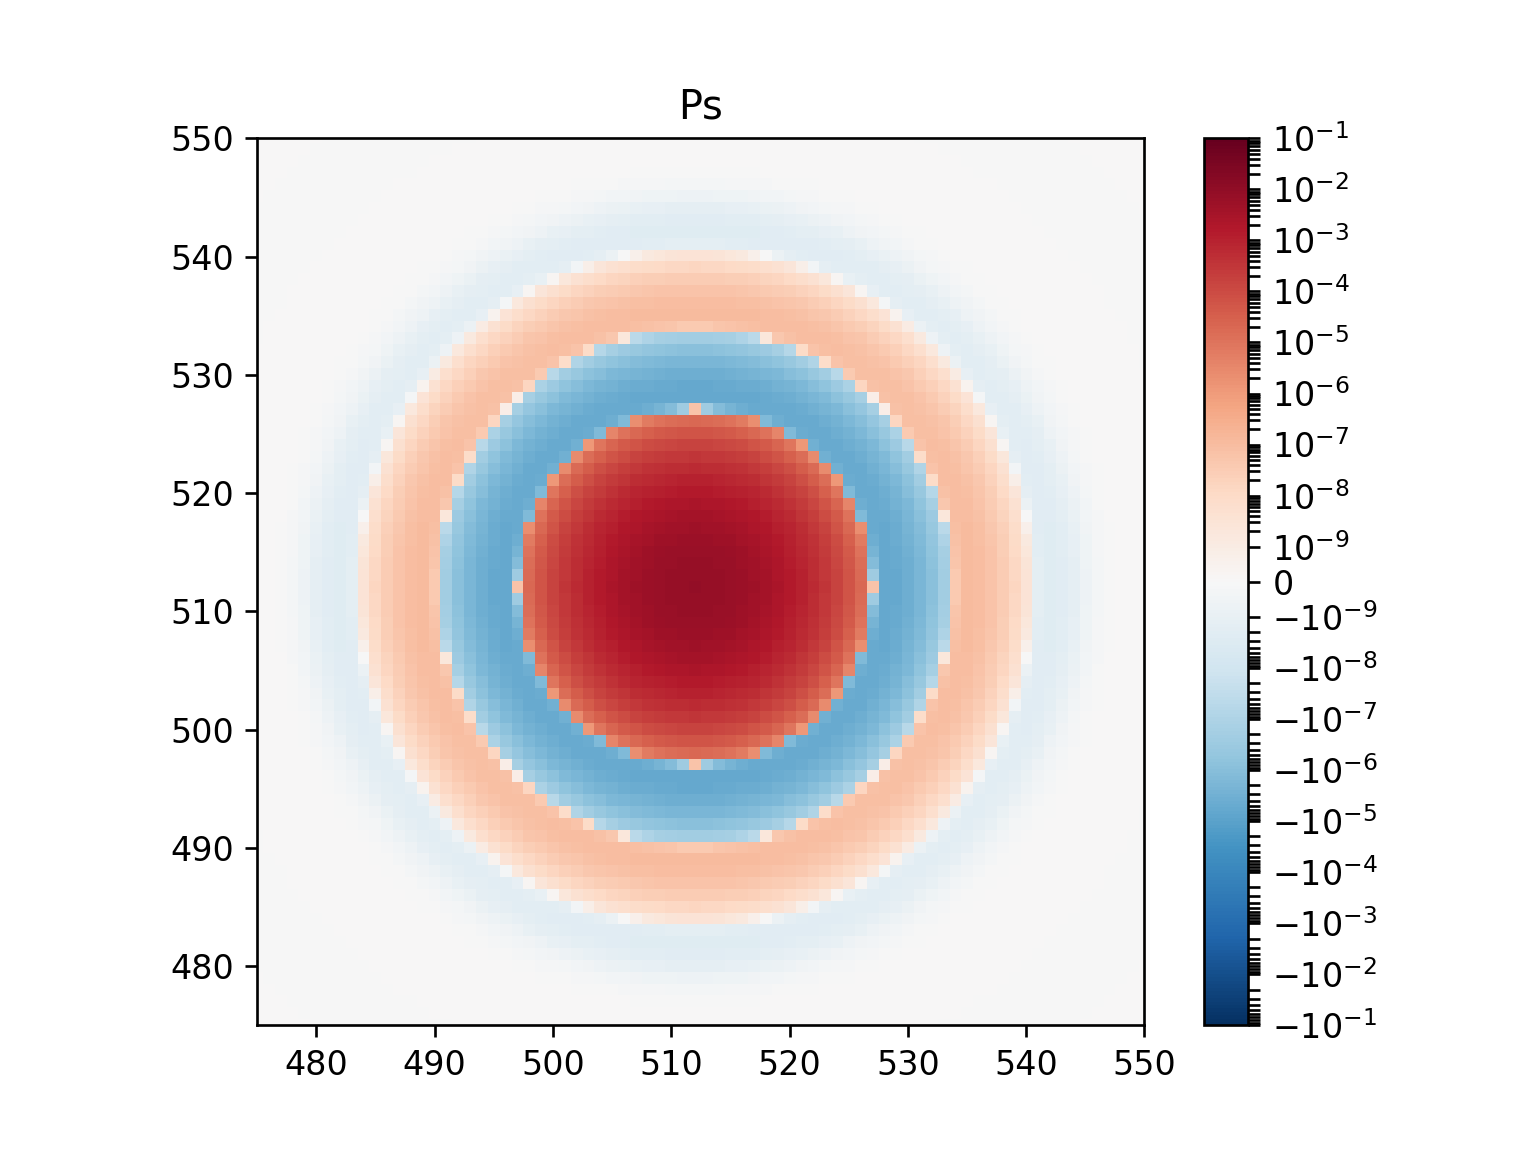

Text(0.5, 1.0, 'Ps')

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(Ps, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-9,vmin=-0.1,vmax=0.1))
ax.set_ylim(475, 550)
ax.set_xlim(475, 550)
fig.colorbar(cs)
ax.set_title("Ps")

In [19]:
fig.savefig("twoG_defaults_Ps.pdf")

Matching kernel for the score image

<IPython.core.display.Javascript object>


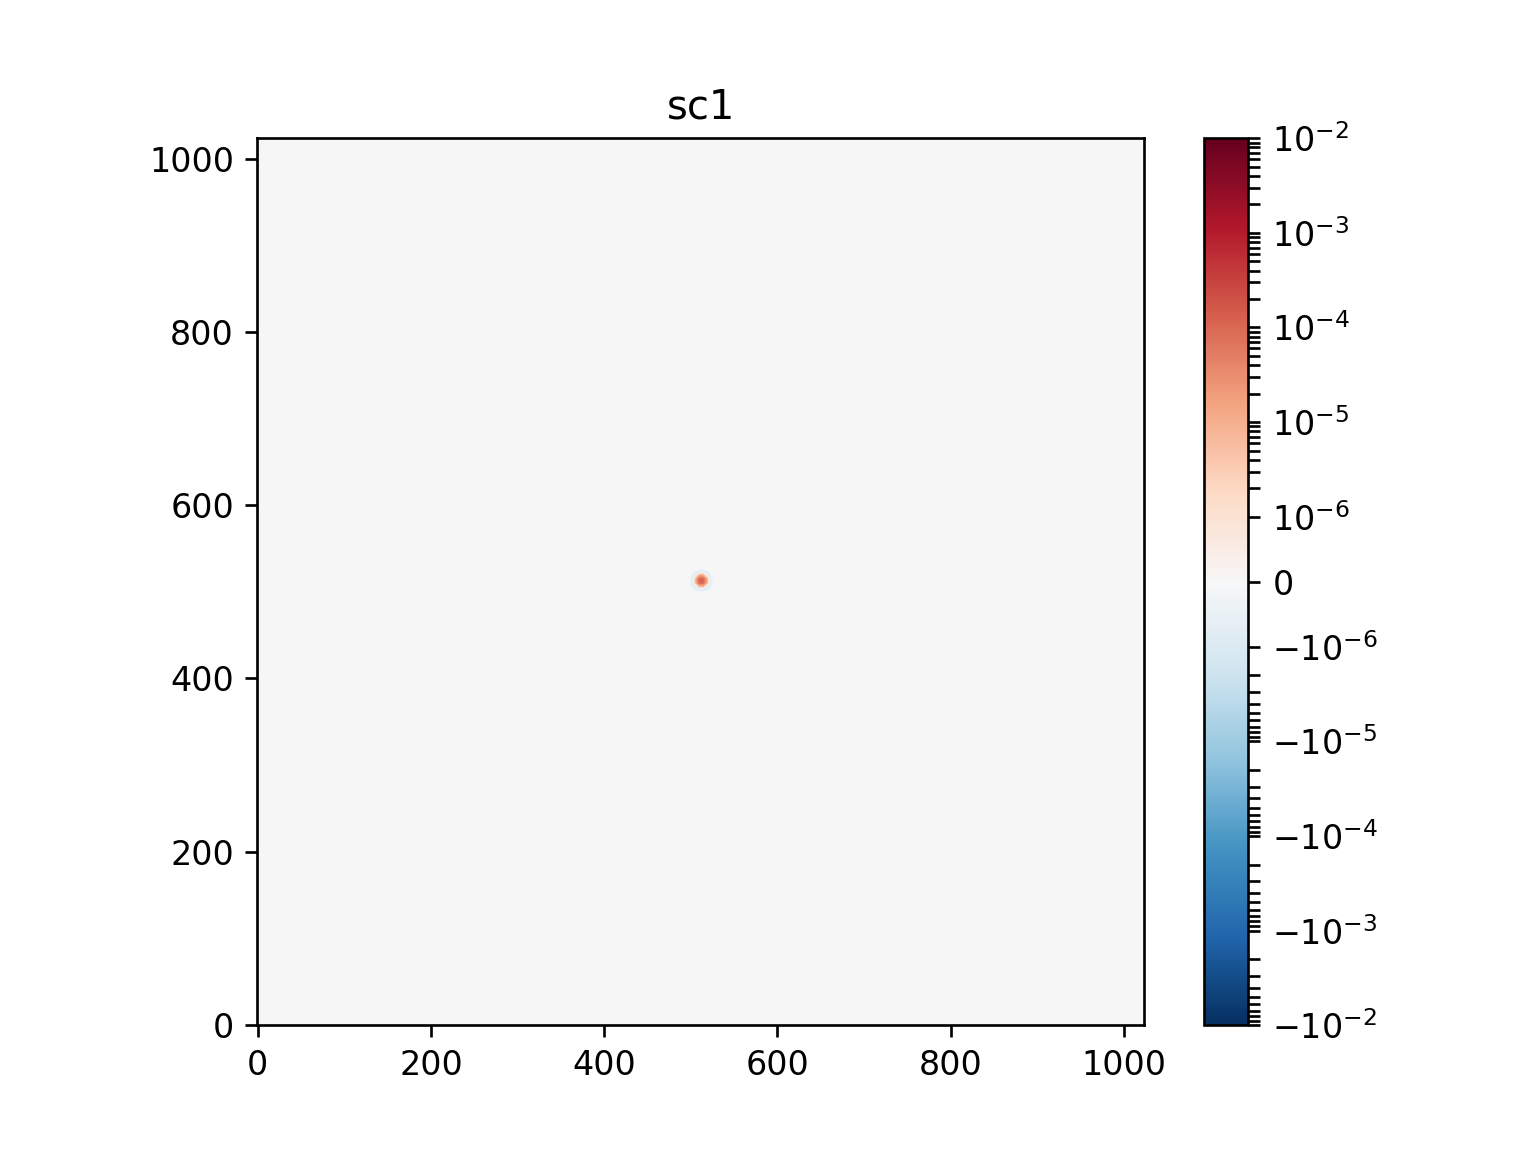

Text(0.5, 1.0, 'sc1')

In [36]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(sc1, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.01,vmax=0.01))
fig.colorbar(cs)
ax.set_title("sc1")

Try whether the matching kernel for the difference image, for the score image
and the PSF of the difference image can be given an estimated "radius"

In [37]:
print(estimateFourCornerSize(Pd,1. - 1e-3))
print(estimateFourCornerSize(c1,1. - 1e-3))
print(estimateFourCornerSize(sc1,1. - 1e-3))

(array([8, 7, 7, 8]), array([8, 8, 7, 7]))
(array([129, 511,  87,  49]), array([129,  49,  87, 511]))
(array([7, 6, 5, 6]), array([7, 6, 5, 6]))


The size of c1 cannot really be estimated here...

--------
## double size padding, same weights, Gaussians

In [39]:
A = im1ex.getPsf().computeImage().array
pA = task.padCenterOriginArray(A,(2048,2048))
print(estimateFourCornerSize(pA,1. - 1e-4))
pA = np.fft.fft2(pA)
B = im2ex.getPsf().computeImage().array
pB = task.padCenterOriginArray(B,(2048,2048))
pB = np.fft.fft2(pB)

fPd, fc1, fsc1, _ = calculatePd(pA,100,pB,100)

(array([12, 11, 11, 12]), array([12, 12, 11, 11]))
Handling 0 both PSFs are zero points.


In [40]:
Pd = np.real(np.fft.ifft2(fPd))
c1 = np.real(np.fft.ifft2(fc1))
sc1 = np.real(np.fft.ifft2(fsc1))

<IPython.core.display.Javascript object>


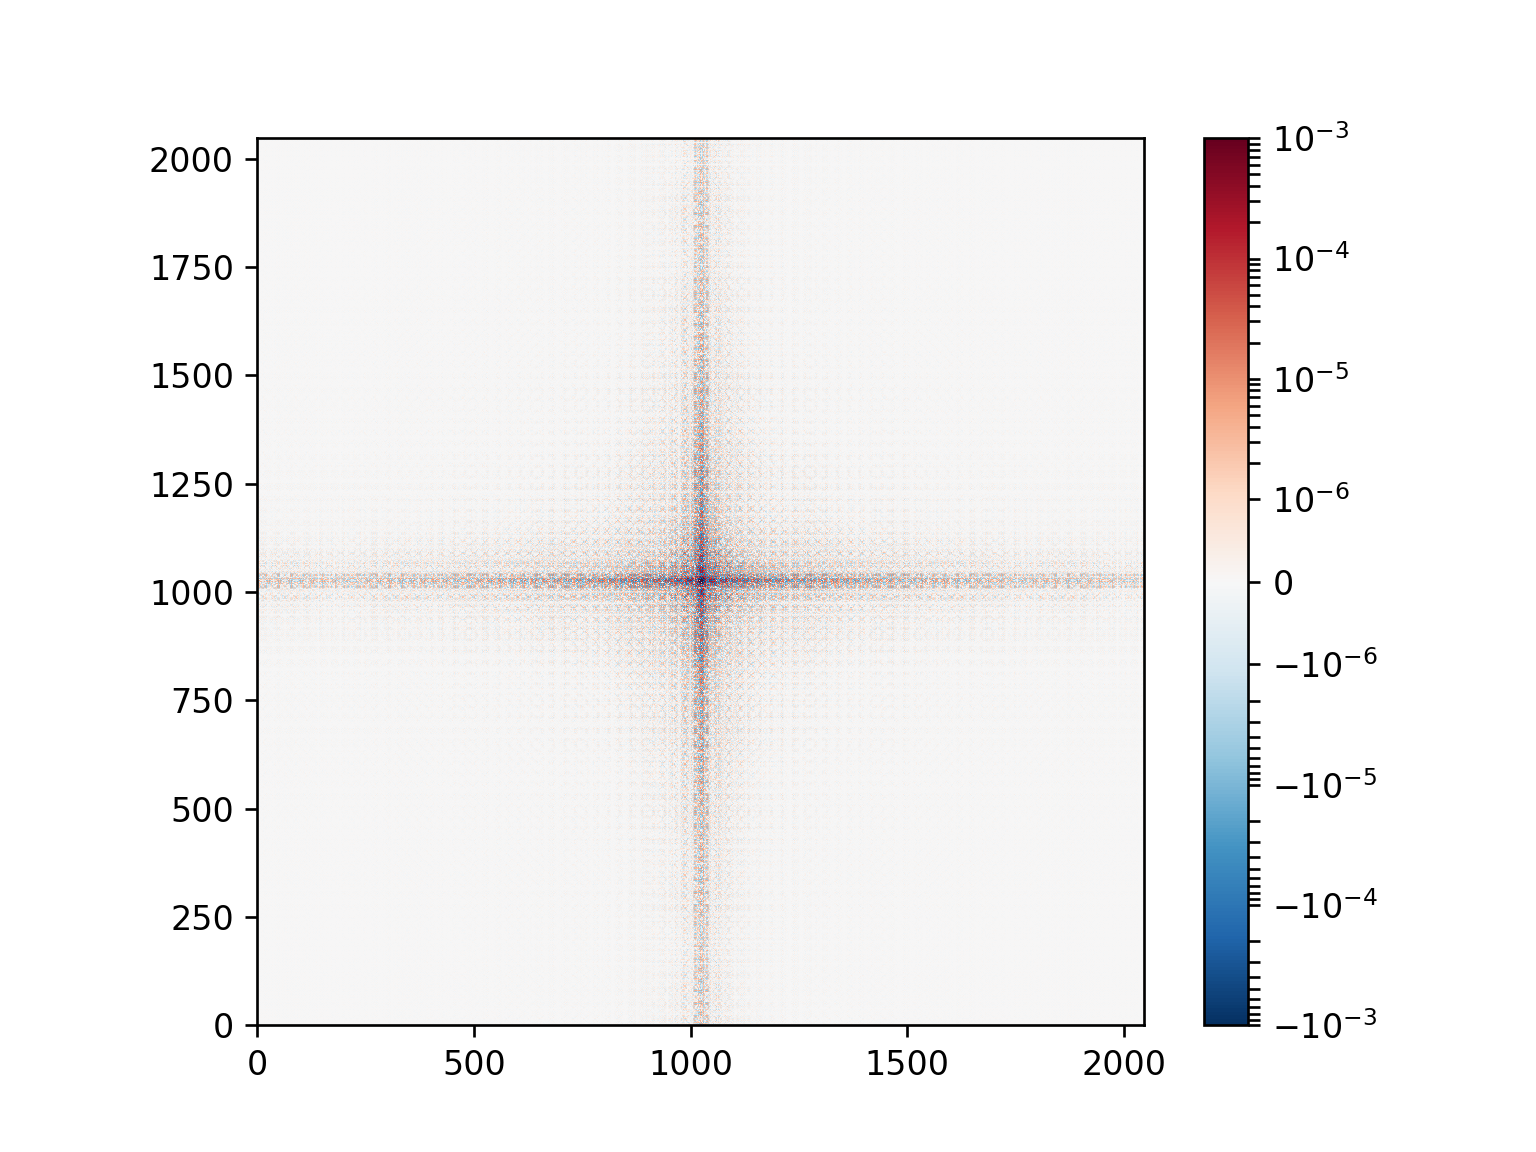

In [42]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(c1, (2048,2048), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.001,vmax=0.001))
fig.colorbar(cs)

In [43]:
print(estimateFourCornerSize(Pd,1. - 1e-2))
print(estimateFourCornerSize(c1,1. - 1e-2))
print(estimateFourCornerSize(sc1,1. - 1e-2))

(array([7, 6, 6, 7]), array([7, 7, 6, 6]))
(array([   1,   24, 1024,   49]), array([   1,   49, 1024,   24]))
(array([5, 4, 4, 5]), array([5, 5, 4, 4]))


<IPython.core.display.Javascript object>


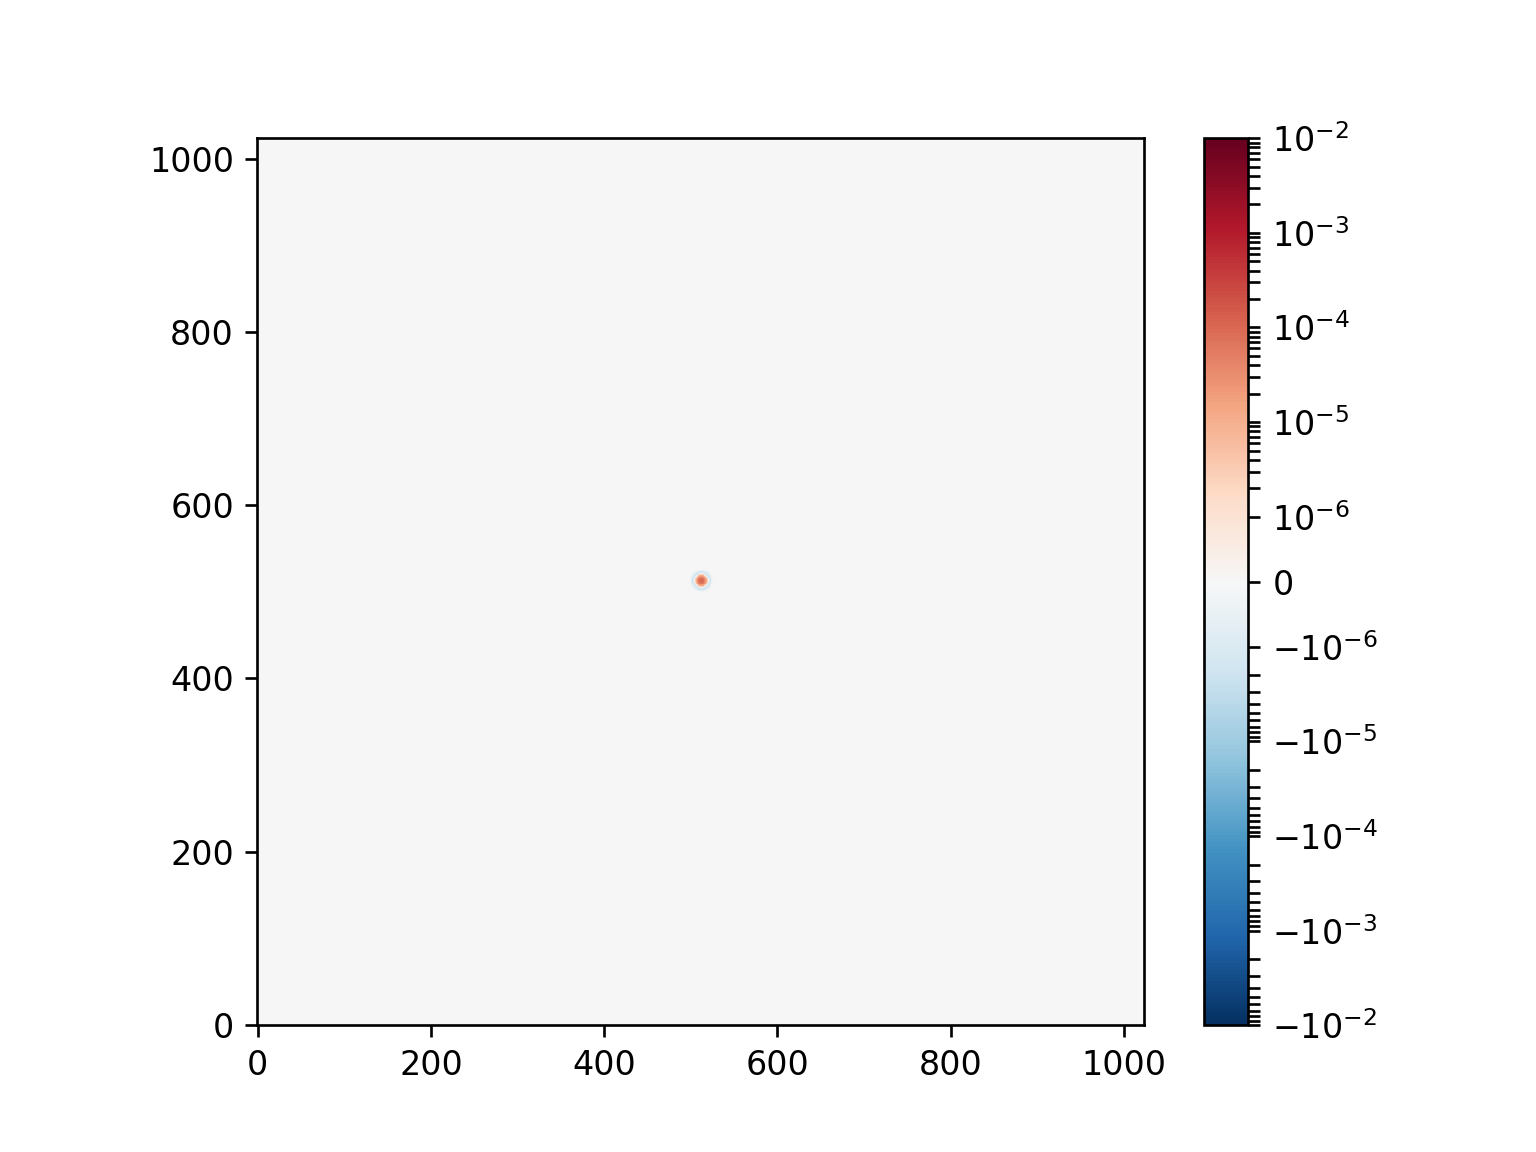

In [44]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(sc1, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.01,vmax=0.01))
fig.colorbar(cs)

------

## Square PSFs
Let's see how Pd and Ps look like for square PSFs, whether the "radius" depend on the padding size

In [46]:
# square psf
A = np.ones((5,5))
A /= np.sum(A)
pA = task.padCenterOriginArray(A,(1024,1024))
print(estimateFourCornerSize(pA,1. - 1e-4))
pA = np.fft.fft2(pA)

B = np.ones((3,3))
B /= np.sum(B)
pB = task.padCenterOriginArray(B,(1024,1024))
pB = np.fft.fft2(pB)

fPd, fc1, fsc1, _ = calculatePd(pA,100,pB,100)

(array([2, 1, 1, 2]), array([2, 2, 1, 1]))
Handling 0 both PSFs are zero points.


In [47]:
Ps = np.real(np.fft.ifft2(np.conj(fPd)*fPd))

<IPython.core.display.Javascript object>


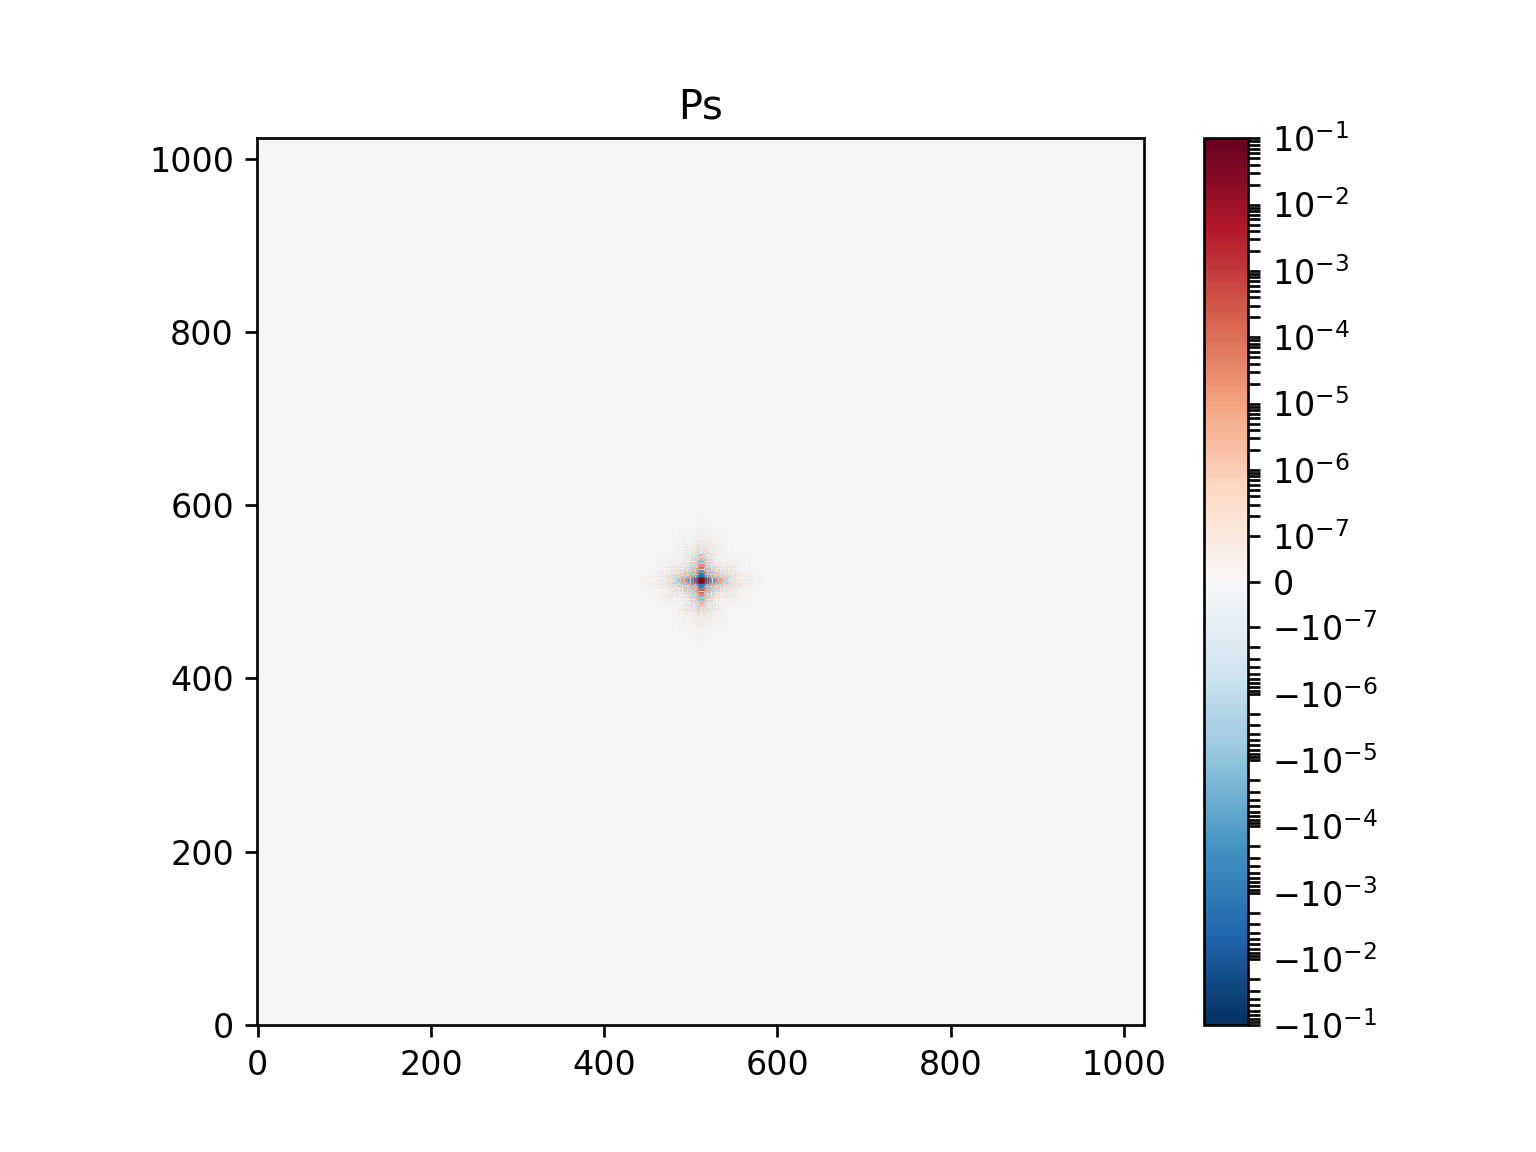

Text(0.5, 1.0, 'Ps')

In [48]:
Pd = np.real(np.fft.ifft2(fPd))
c1 = np.real(np.fft.ifft2(fc1))
sc1 = np.real(np.fft.ifft2(fsc1))

P2 = task.padCenterOriginArray(Ps, (1024,1024), useInverse=True)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-7,vmin=-0.1,vmax=0.1))
fig.colorbar(cs)
ax.set_title("Ps")

In [50]:
# 99.99 radius
Rs = estimateFourCornerSize(Ps,1. - 1e-2)
Rd = estimateFourCornerSize(Pd, 1. - 1e-2)
Rc1 = estimateFourCornerSize(c1, 1. - 1e-2)
Rsc1 = estimateFourCornerSize(sc1, 1. - 1e-2)
print(Rs)
print(Rd)
print(Rc1)
print(Rsc1)
Rs = np.amax(Rs)
Rd = np.amax(Rd)

(array([4, 3, 3, 4]), array([4, 4, 3, 3]))
(array([6, 5, 5, 6]), array([6, 6, 5, 5]))
(array([9, 5, 5, 9]), array([9, 9, 5, 5]))
(array([2, 5, 6, 2]), array([2, 2, 6, 5]))


<IPython.core.display.Javascript object>


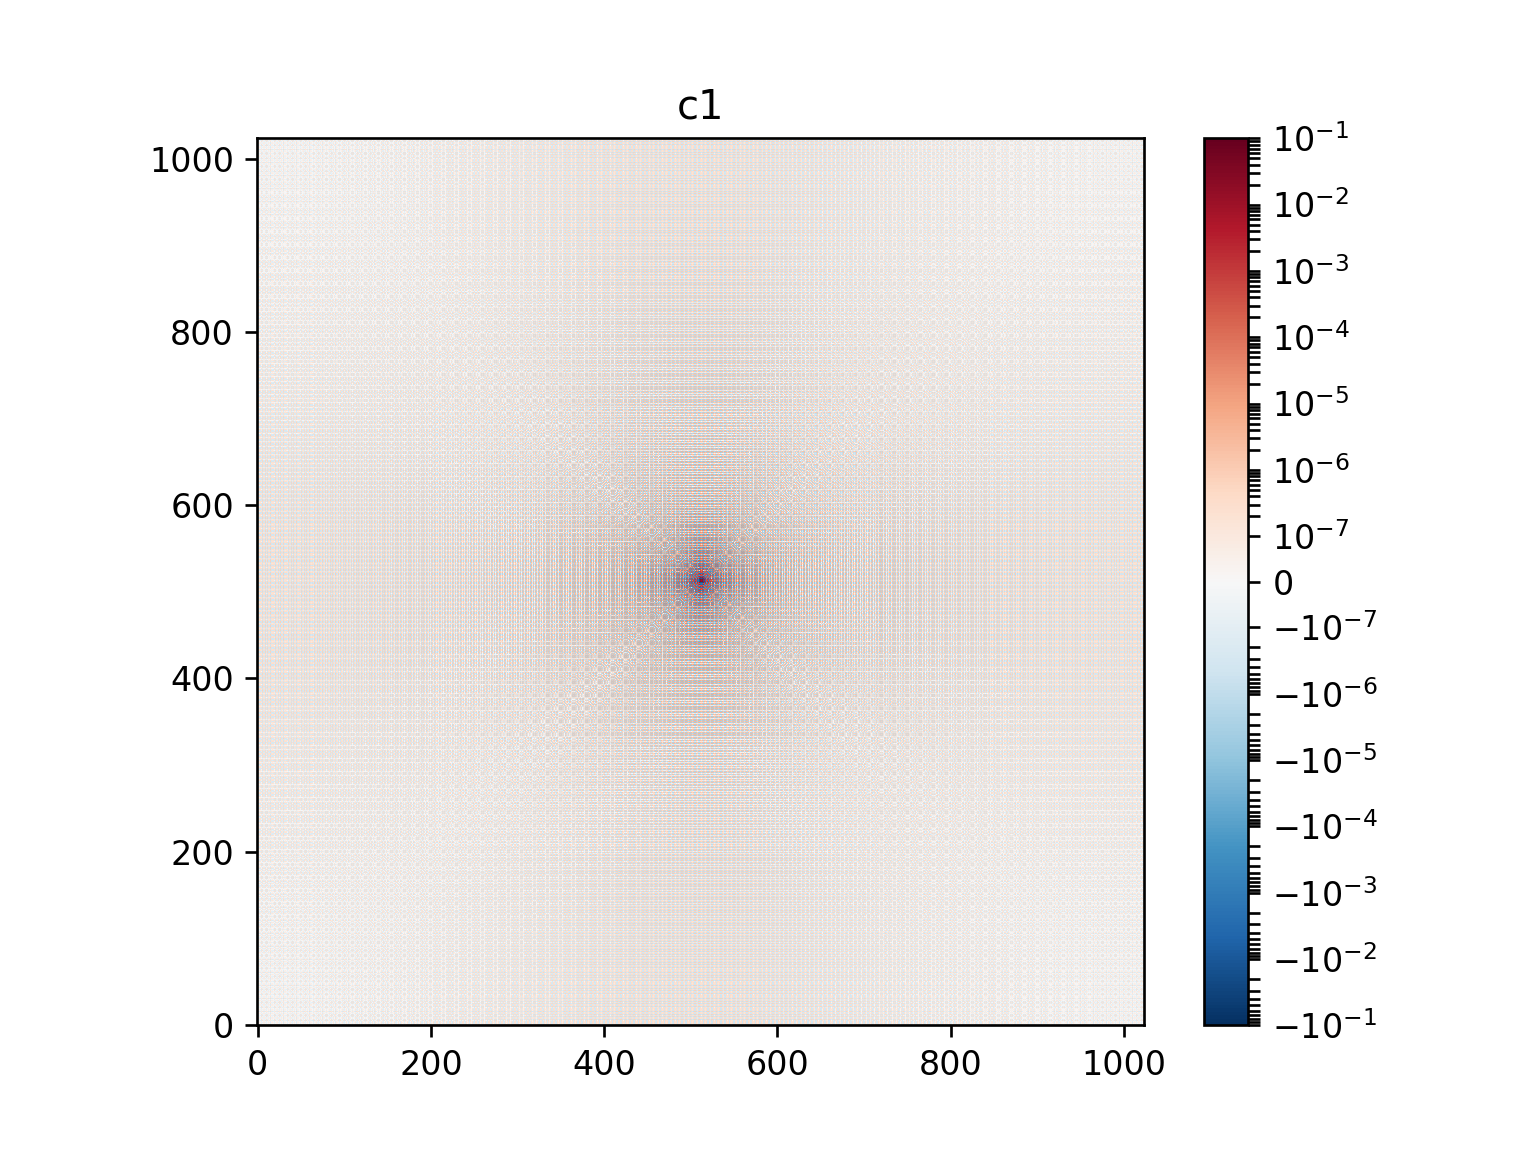

Text(0.5, 1.0, 'c1')

In [51]:
P2 = task.padCenterOriginArray(c1, (1024,1024), useInverse=True)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-7,vmin=-0.1,vmax=0.1))
fig.colorbar(cs)
ax.set_title("c1")

<IPython.core.display.Javascript object>


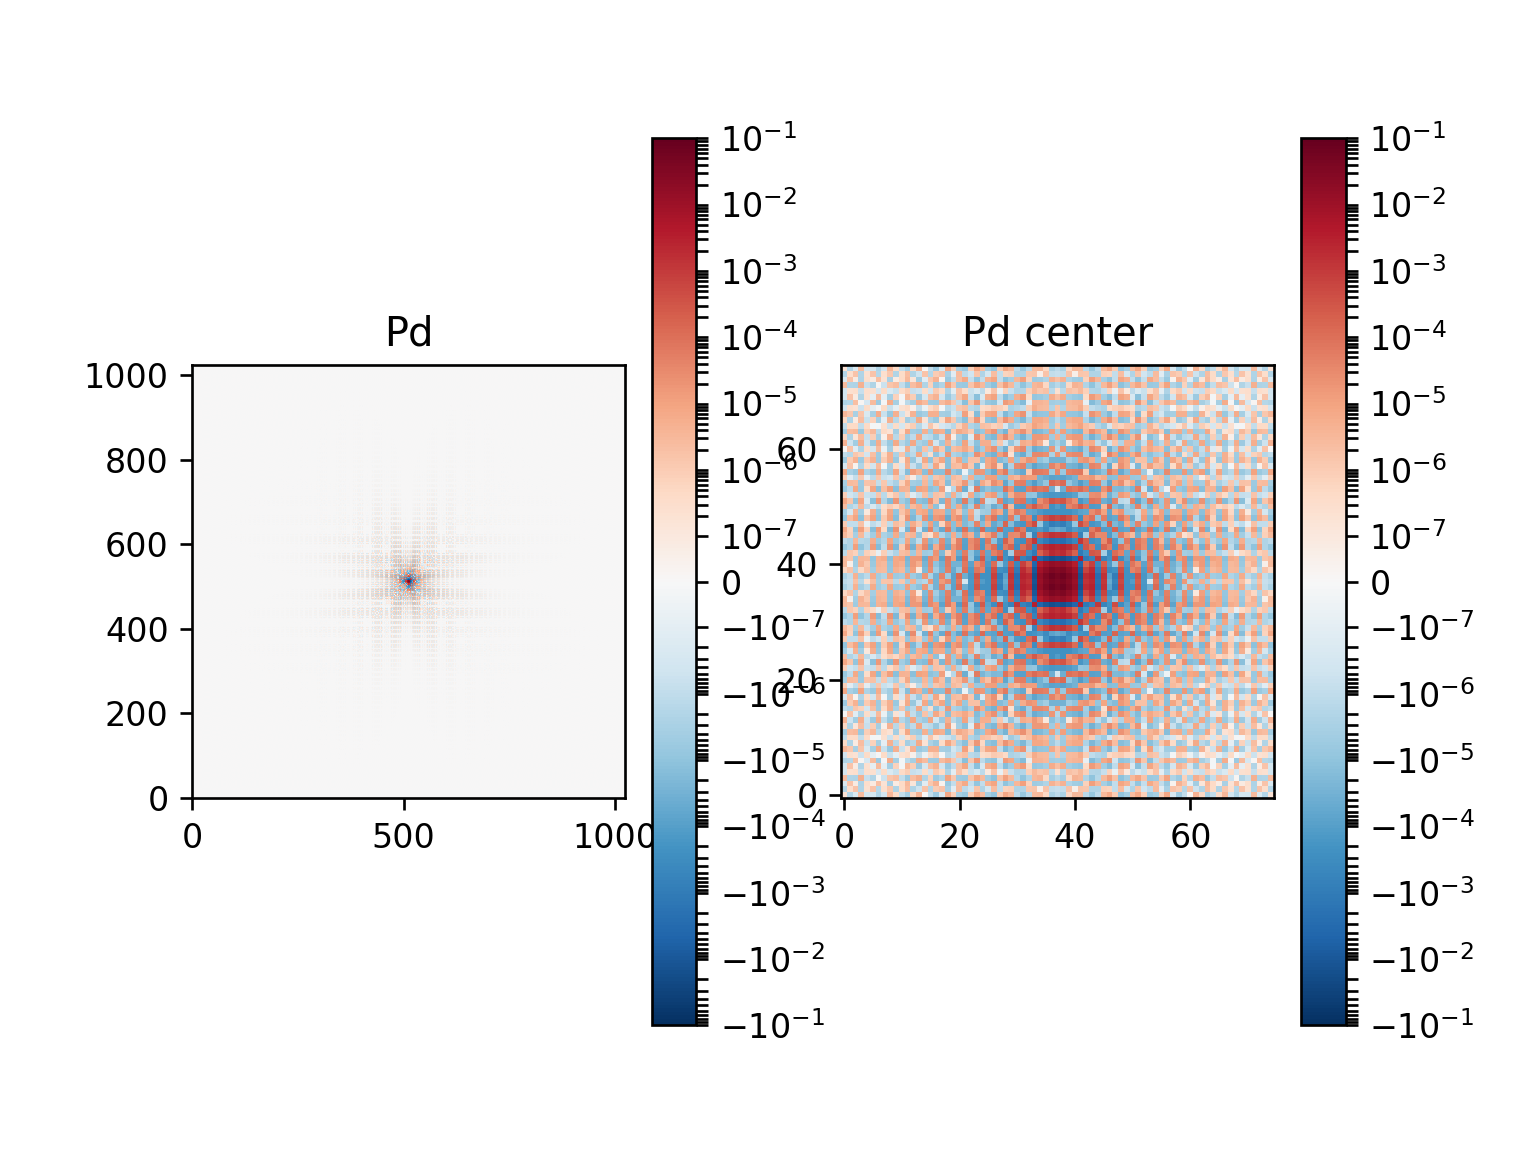

Text(0.5, 1.0, 'Pd center')

In [52]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
P2 = task.padCenterOriginArray(Pd, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-7,vmin=-0.1,vmax=0.1))
fig.colorbar(cs)
ax.set_title("Pd")


ax = fig.add_subplot(1, 2, 2)
cs = ax.imshow(P2[475:550, 475:550], interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-7,vmin=-0.1,vmax=0.1))
fig.colorbar(cs)
ax.set_title("Pd center")

------
## double padding, square PSF


In [ ]:
# square psf
A = np.ones((5,5))
A /= np.sum(A)
pA = task.padCenterOriginArray(A,(2048,2048))
print(estimateFourCornerSize(pA,1. - 1e-4))
pA = np.fft.fft2(pA)

B = np.ones((3,3))
B /= np.sum(B)
pB = task.padCenterOriginArray(B,(2048,2048))
pB = np.fft.fft2(pB)

Pd = calculatePd(pA,100,pB,100)

In [ ]:
Ps = np.real(np.fft.ifft2(np.conj(Pd)*Pd))
Pd = np.real(np.fft.ifft2(Pd))

In [ ]:
P2 = task.padCenterOriginArray(Ps, (2048,2048), useInverse=True)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.1,vmax=0.1))
fig.colorbar(cs)

In [ ]:
# 99.9% radius
Rs = estimateFourCornerSize(Ps,1. - 1e-3)
Rd = estimateFourCornerSize(Pd, 1. - 1e-3)
print(Rs)
print(Rd)
Rs = np.amax(Rs)
Rd = np.amax(Rd)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
cs = ax.imshow(Pd[:Rd,:Rd], interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.1,vmax=0.1))
fig.colorbar(cs)

--------
## Very well sampled PSF with exact zeroes

### Identical Gaussians, show c1, Pd
Fourier transform is not exact enough to go to exact zero, fluctuates around epsilon value

2048 x 2048 case

In [53]:
import scipy.stats
# Very well sampled
#x, y = np.meshgrid(np.arange(-80,81),np.arange(-80,81))
# Cut off at ~3 sigma
x, y = np.meshgrid(np.arange(-12,13),np.arange(-12,13))
c = np.stack((x,y), axis=-1)
print(x.shape, c.shape)

(25, 25) (25, 25, 2)


In [54]:
rv = scipy.stats.multivariate_normal([0.,0.],[[4.,0],[0,4.]])
psf = rv.pdf(c)
Ppsf1 = task.padCenterOriginArray(psf,(2048,2048))

rv = scipy.stats.multivariate_normal([0.,0.],[[16.,0],[0,16.]])
psf = rv.pdf(c)
Ppsf2 = task.padCenterOriginArray(psf,(2048,2048))

In [56]:
pA = np.fft.fft2(Ppsf1)
pB = np.fft.fft2(Ppsf1)

fPd, fc1, fsc1, _ = calculatePd(pA,100,pB,100)

Handling 0 both PSFs are zero points.


In [57]:
Pd = np.real(np.fft.ifft2(fPd))
c1 = np.real(np.fft.ifft2(fc1))
sc1 = np.real(np.fft.ifft2(fsc1))

<IPython.core.display.Javascript object>


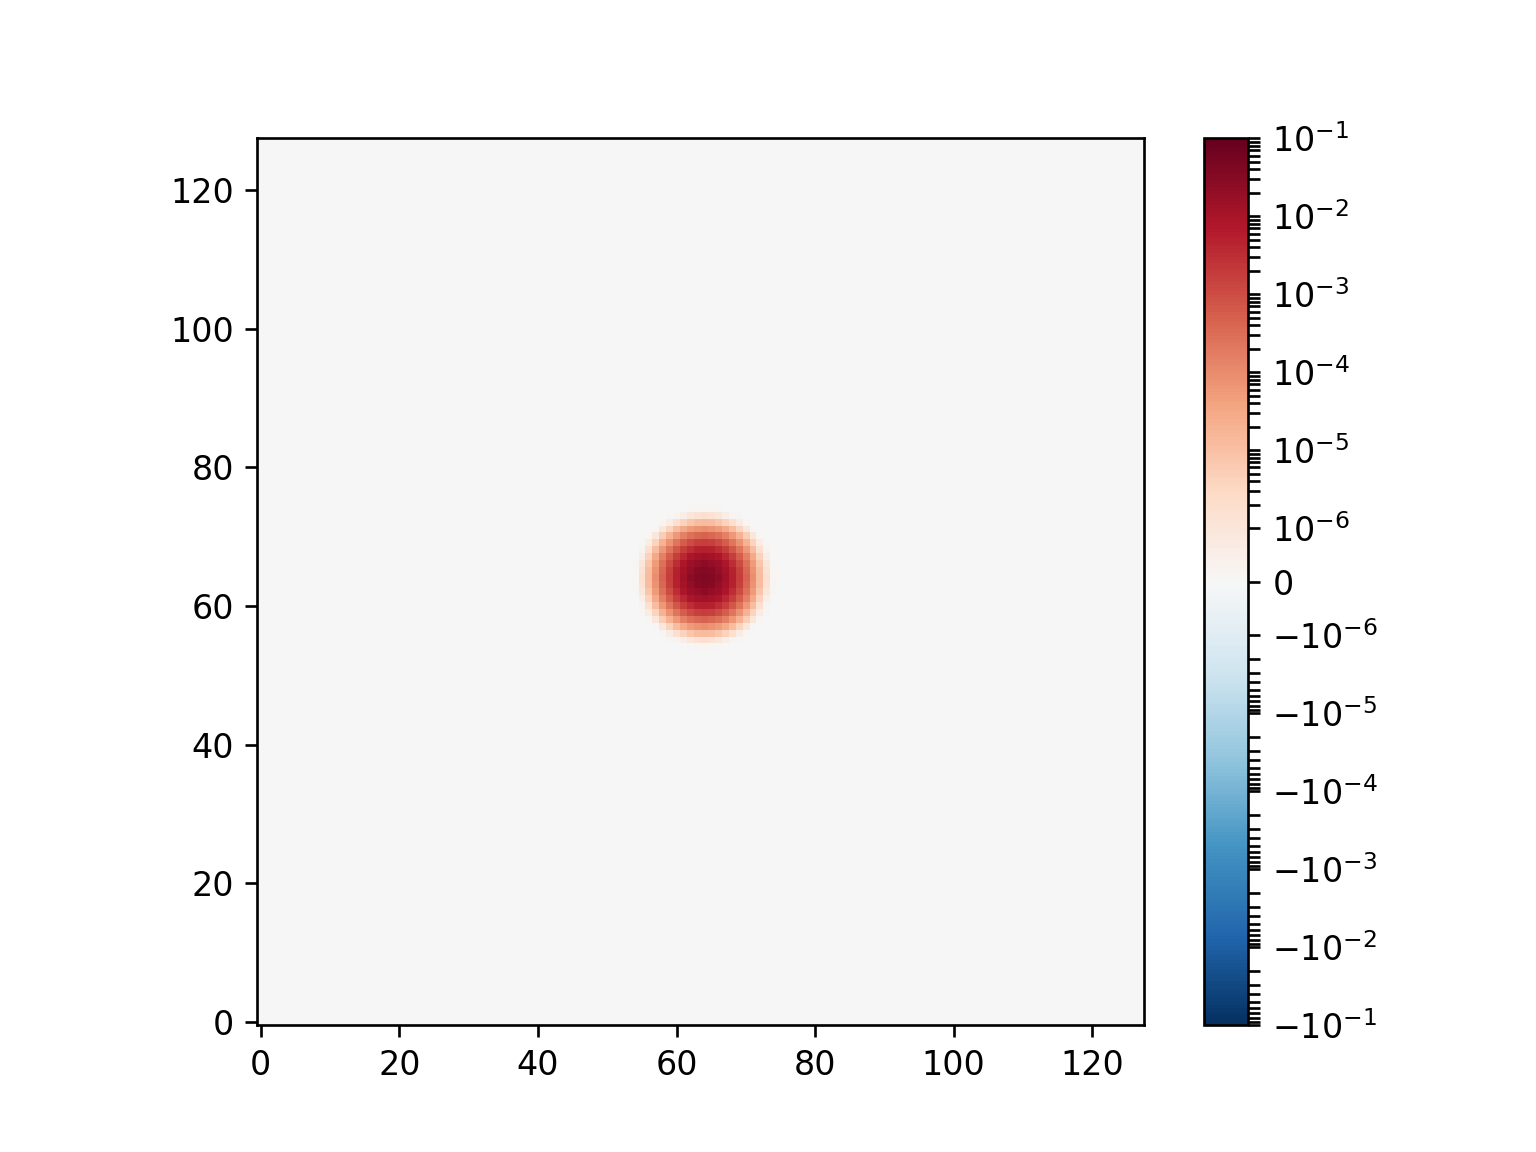

In [58]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(Pd, (128,128), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.1,vmax=0.1))
fig.colorbar(cs)

<IPython.core.display.Javascript object>


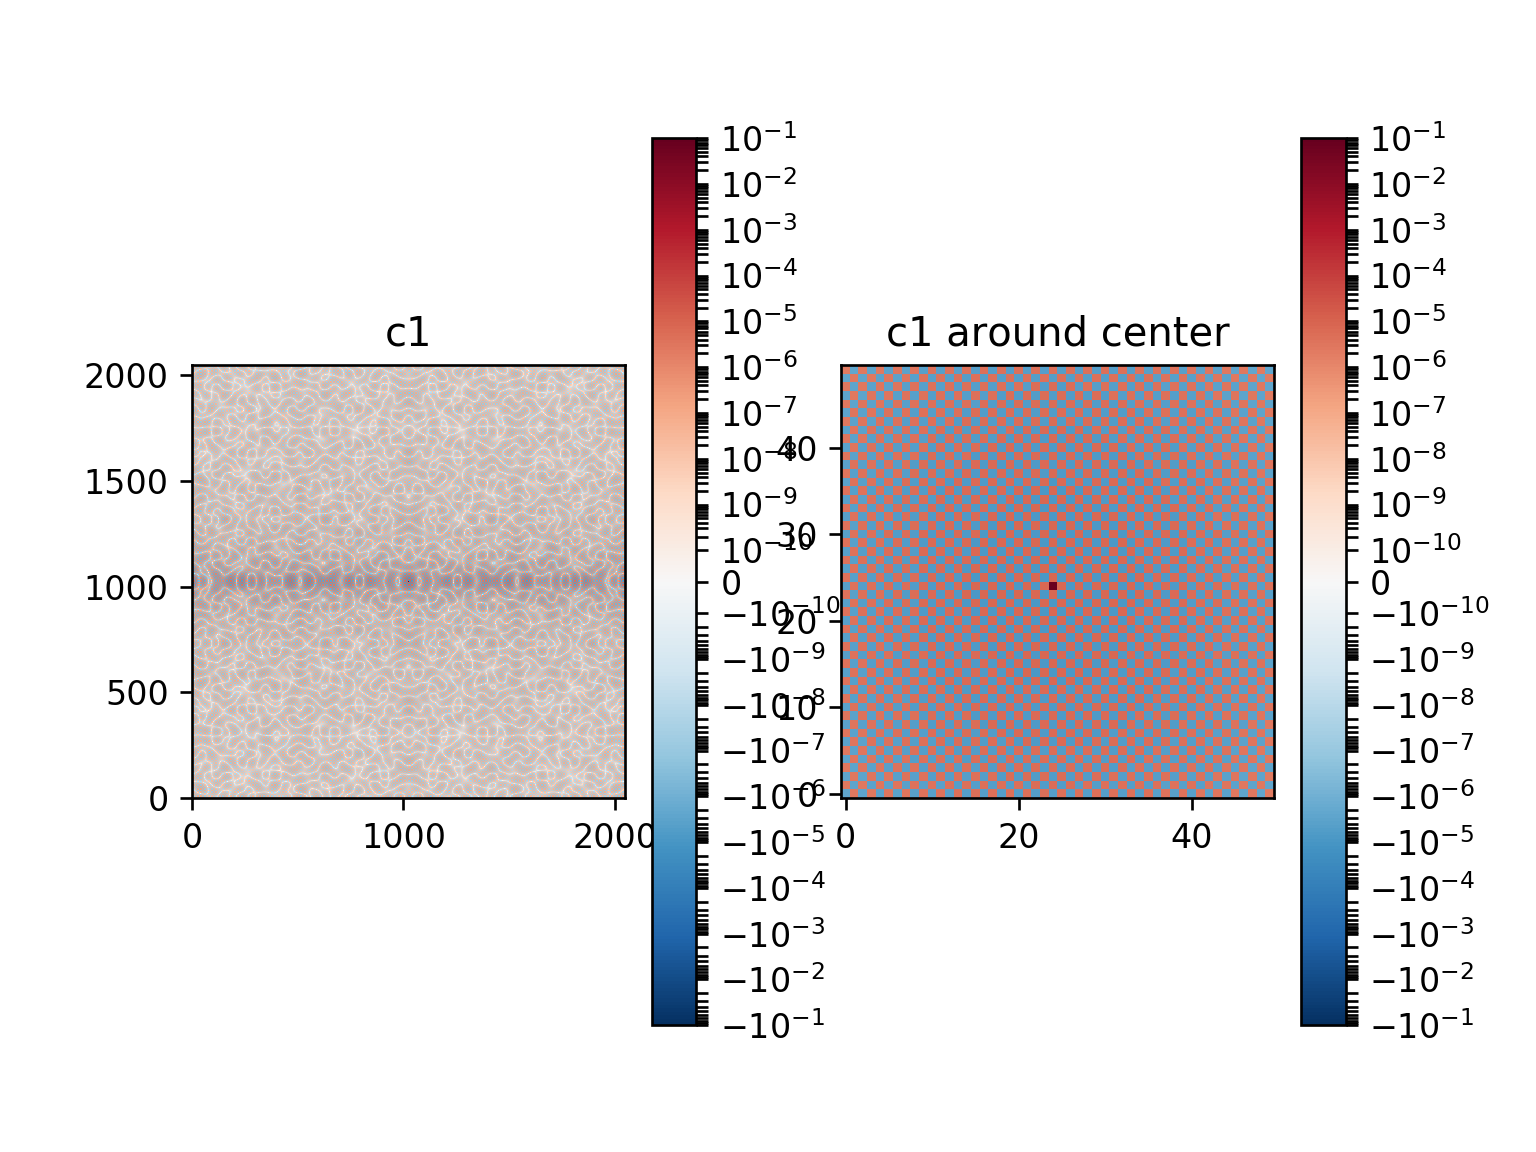

Text(0.5, 1.0, 'c1 around center')

In [59]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
P2 = task.padCenterOriginArray(c1, (2048,2048), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-10,vmin=-0.1,vmax=0.1))
fig.colorbar(cs)
ax.set_title("c1")

ax = fig.add_subplot(1, 2, 2)
P2 = task.padCenterOriginArray(c1, (2048,2048), useInverse=True)
cs = ax.imshow(P2[1000:1050, 1000:1050], interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-10,vmin=-0.1,vmax=0.1))
fig.colorbar(cs)
ax.set_title("c1 around center")

In [61]:
print(estimateFourCornerSize(c1,p=0.99))

(array([   0, 1023,  187, 1023]), array([   0,    2, 1024,    2]))


1024 x 1024 case for comparison below

In [51]:
import scipy.stats
# Very well sampled
#x, y = np.meshgrid(np.arange(-80,81),np.arange(-80,81))
# Cut off at ~3 sigma
x, y = np.meshgrid(np.arange(-12,13),np.arange(-12,13))
c = np.stack((x,y), axis=-1)
print(x.shape, c.shape)

(25, 25) (25, 25, 2)


In [52]:
rv = scipy.stats.multivariate_normal([0.,0.],[[4.,0],[0,4.]])
psf = rv.pdf(c)
Ppsf1 = task.padCenterOriginArray(psf,(1024, 1024))

rv = scipy.stats.multivariate_normal([0.,0.],[[16.,0],[0,16.]])
psf = rv.pdf(c)
Ppsf2 = task.padCenterOriginArray(psf,(1024, 1024))

In [53]:
pA = np.fft.fft2(Ppsf1)
pB = np.fft.fft2(Ppsf1)

fPd, fc1, fsc1, _ = calculatePd(pA,100,pB,100)

Handling 0 both PSFs are zero points.


In [54]:
Pd = np.real(np.fft.ifft2(fPd))
c1 = np.real(np.fft.ifft2(fc1))
sc1 = np.real(np.fft.ifft2(fsc1))

<IPython.core.display.Javascript object>


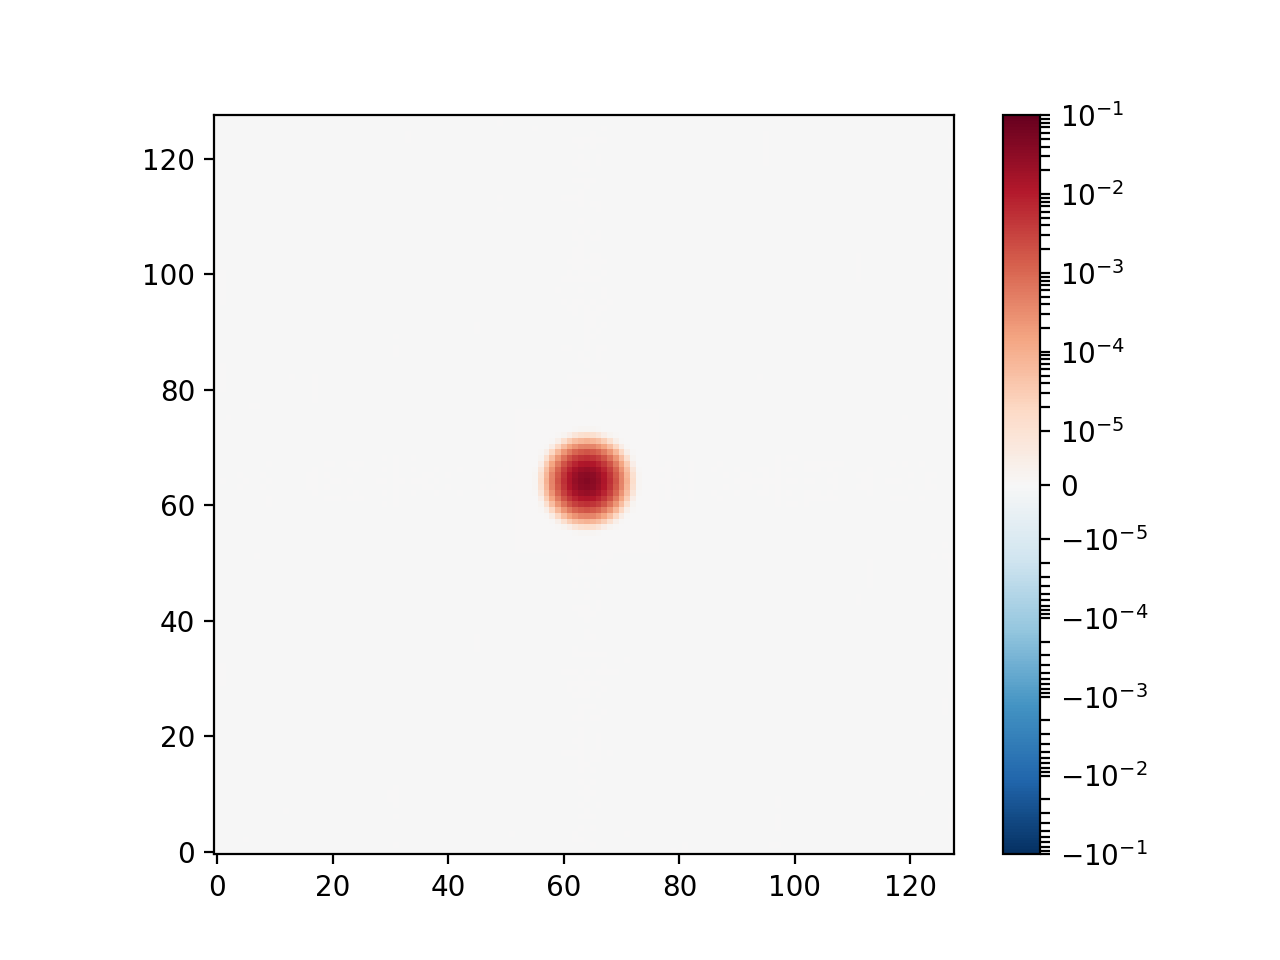

In [55]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(Pd, (128,128), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-5,vmin=-0.1,vmax=0.1))
fig.colorbar(cs)

<IPython.core.display.Javascript object>


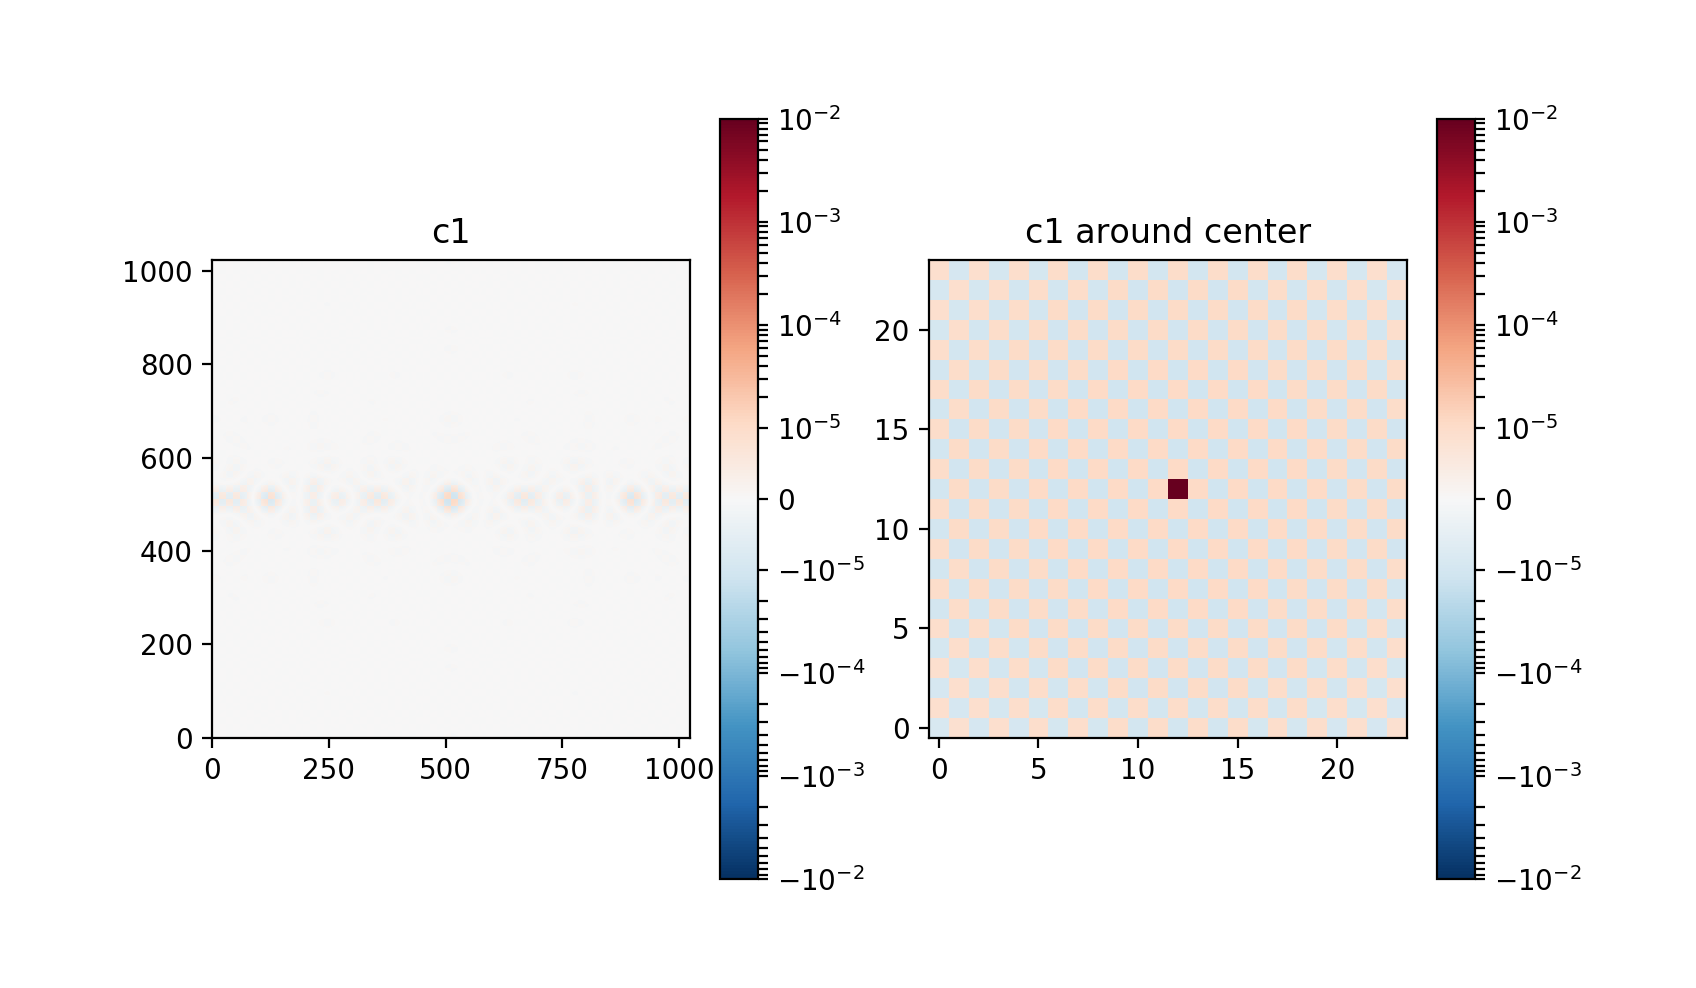

Text(0.5, 1.0, 'c1 around center')

In [58]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
P2 = task.padCenterOriginArray(c1, (1024, 1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-5,vmin=-0.01,vmax=0.01))
fig.colorbar(cs)
ax.set_title("c1")

ax = fig.add_subplot(1, 2, 2)
P2 = task.padCenterOriginArray(c1, (1024, 1024), useInverse=True)
cs = ax.imshow(P2[500:524, 500:524], interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-5,vmin=-0.01,vmax=0.01))
fig.colorbar(cs)
ax.set_title("c1 around center")

In [41]:
fig.savefig("identical_Gaussians_1024.pdf")

### Compare makeFakeImages and scipy pdf

In [56]:
A = im1ex.getPsf().computeImage().array
pA = task.padCenterOriginArray(A,(1024,1024))
print(estimateFourCornerSize(pA,1. - 1e-4))
print(A.shape)
pA = np.fft.fft2(pA)
B = im2ex.getPsf().computeImage().array
pB = task.padCenterOriginArray(B,(1024,1024))
pB = np.fft.fft2(pB)

fPd, fc1, fsc1, _ = calculatePd(pA,100,pB,50)

(array([12, 11, 11, 12]), array([12, 12, 11, 11]))
(25, 25)
Handling 0 both PSFs are zero points.


In [57]:
Pd = np.real(np.fft.ifft2(fPd))
c1 = np.real(np.fft.ifft2(fc1))
sc1 = np.real(np.fft.ifft2(fsc1))

<IPython.core.display.Javascript object>


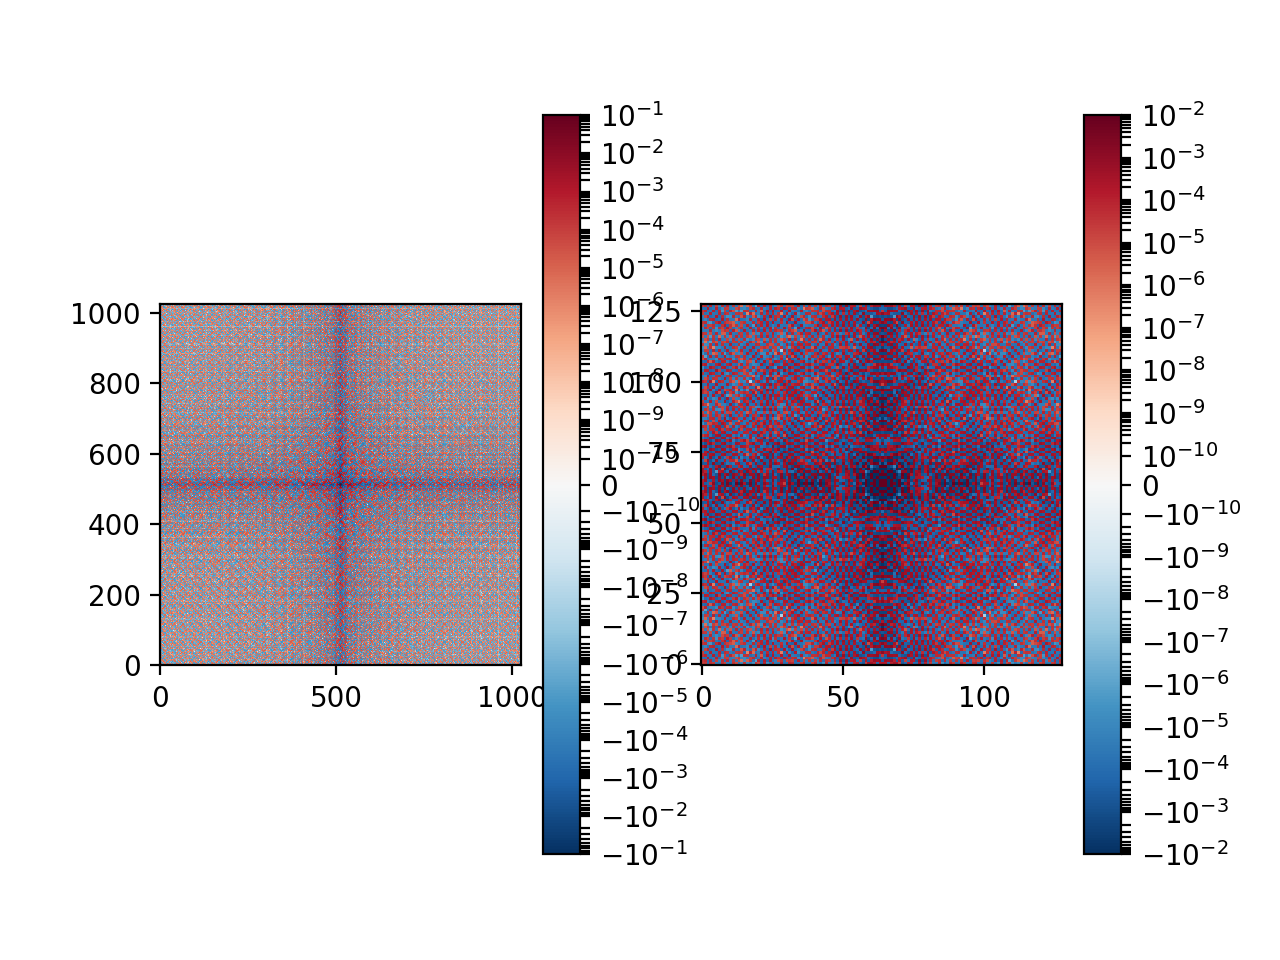

In [58]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
P2 = task.padCenterOriginArray(c1/np.sum(c1), (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-10,vmin=-0.1,vmax=0.1))
fig.colorbar(cs)

ax = fig.add_subplot(1, 2, 2)
P2 = task.padCenterOriginArray(c1/np.sum(c1), (1024,1024), useInverse=True)
cs = ax.imshow(P2[448:576, 448:576], interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-10,vmin=-0.01,vmax=0.01))
fig.colorbar(cs)

------

### Two well sampled Gaussians, different sigma, try psf cut

In [87]:
import scipy.stats
# Very well sampled
x, y = np.meshgrid(np.arange(-80,81),np.arange(-80,81))
# Cut off at ~3 sigma
#x, y = np.meshgrid(np.arange(-12,13),np.arange(-12,13))
coord = np.stack((x,y), axis=-1)
print(x.shape, c.shape)

(161, 161) (25, 25, 2)


In [60]:
thresh = np.finfo(float).eps

In [45]:
rv1 = scipy.stats.multivariate_normal([0.,0.],[[4.*4.,0],[0,4.*4.]])
psf1 = rv1.pdf(coord)
Ppsf1 = task.padCenterOriginArray(psf1,(1024,1024))
fPpsf1 = np.fft.fft2(Ppsf1)
fPpsf1[np.abs(fPpsf1) < thresh ] = 0.

rv2 = scipy.stats.multivariate_normal([0.,0.],[[6.*6.,0],[0,6.*6.]])
psf2 = rv2.pdf(coord)
Ppsf2 = task.padCenterOriginArray(psf2,(1024,1024))
fPpsf2 = np.fft.fft2(Ppsf2)
fPpsf2[np.abs(fPpsf2) < thresh ] = 0.

In [46]:
fPd, fc1, fsc1, _ = calculatePd(fPpsf1,100,fPpsf2,100)

Handling 672385 both PSFs are zero points.


In [47]:
Pd = np.real(np.fft.ifft2(fPd))
c1 = np.real(np.fft.ifft2(fc1))
sc1 = np.real(np.fft.ifft2(fsc1))
Ps = np.real(np.fft.ifft2(np.conj(fPd)*fPd))

<IPython.core.display.Javascript object>


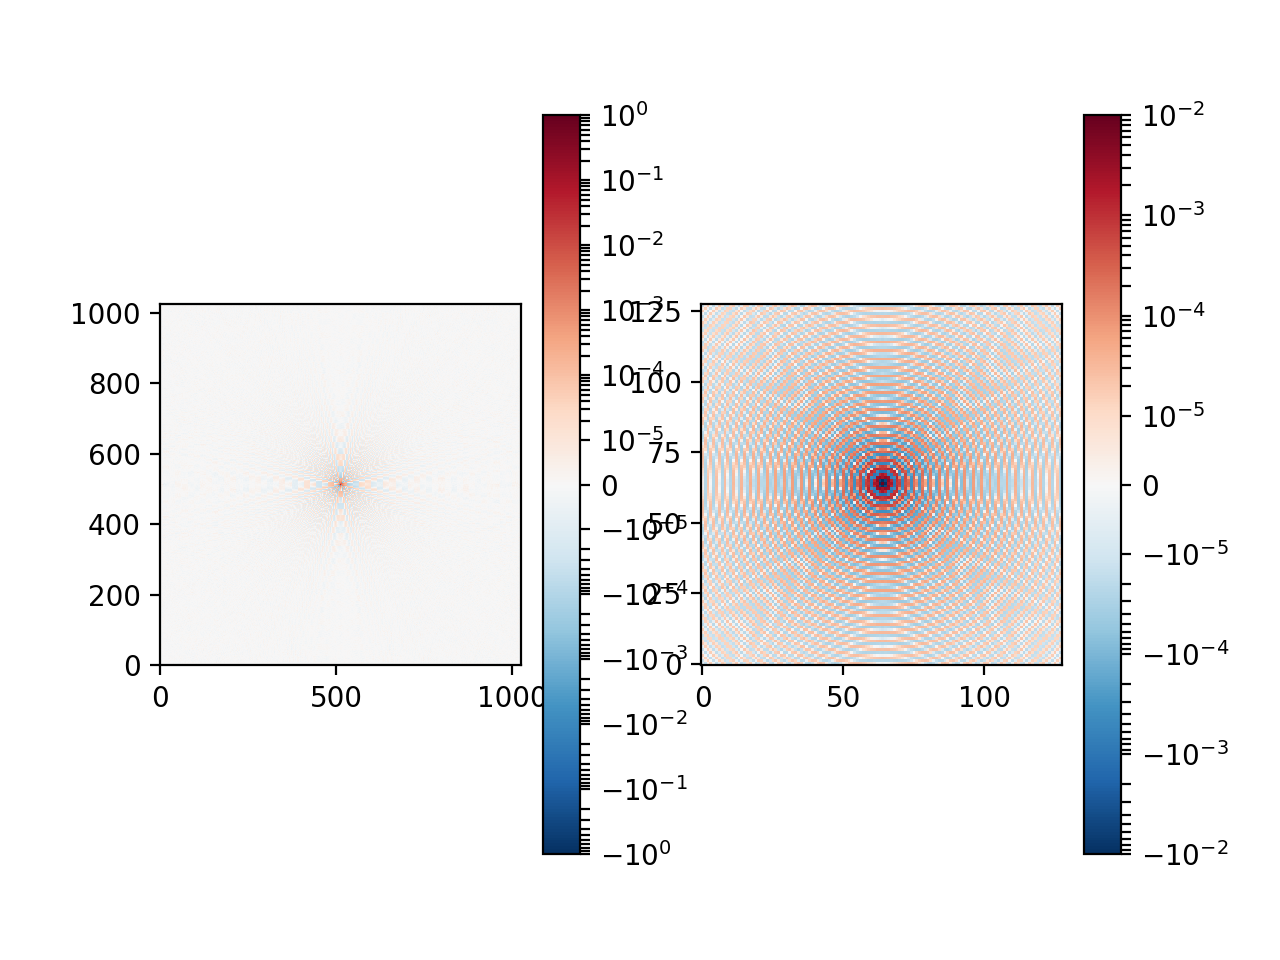

In [50]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
P2 = task.padCenterOriginArray(c1, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-5,vmin=-0.1,vmax=0.1))
fig.colorbar(cs)

ax = fig.add_subplot(1, 2, 2)
P2 = task.padCenterOriginArray(c1, (1024,1024), useInverse=True)
cs = ax.imshow(P2[448:576, 448:576], interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-5,vmin=-0.01,vmax=0.01))
fig.colorbar(cs)

In [253]:
# We don't know why it is x-axis pattern, maybe just plotting rounding
# The + shape appears if the gaussian is not well sampled and cut by the square (see above meshgrid)

<IPython.core.display.Javascript object>


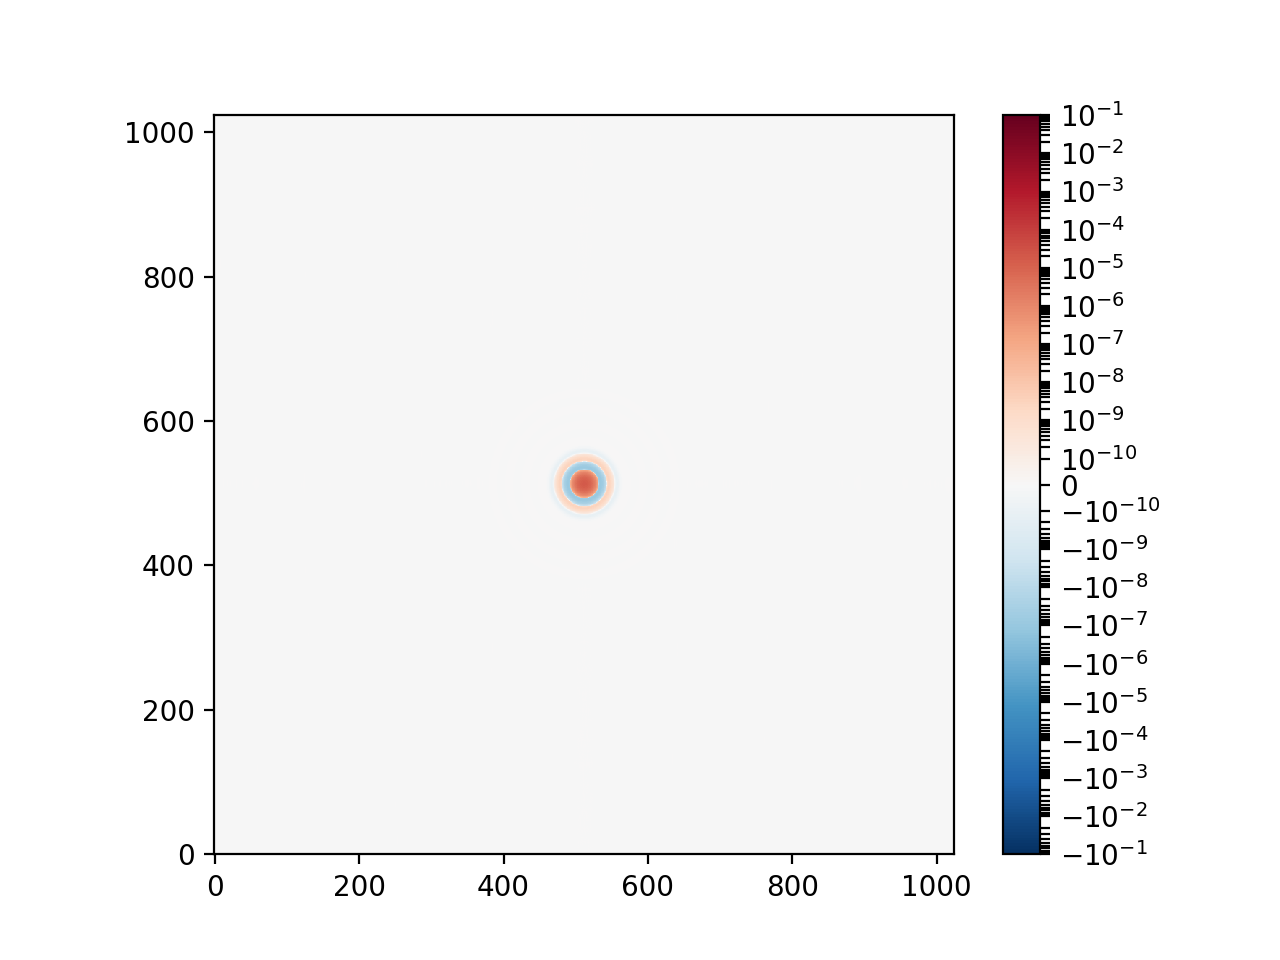

In [30]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(sc1, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-10,vmin=-0.1,vmax=0.1))
fig.colorbar(cs)

<IPython.core.display.Javascript object>


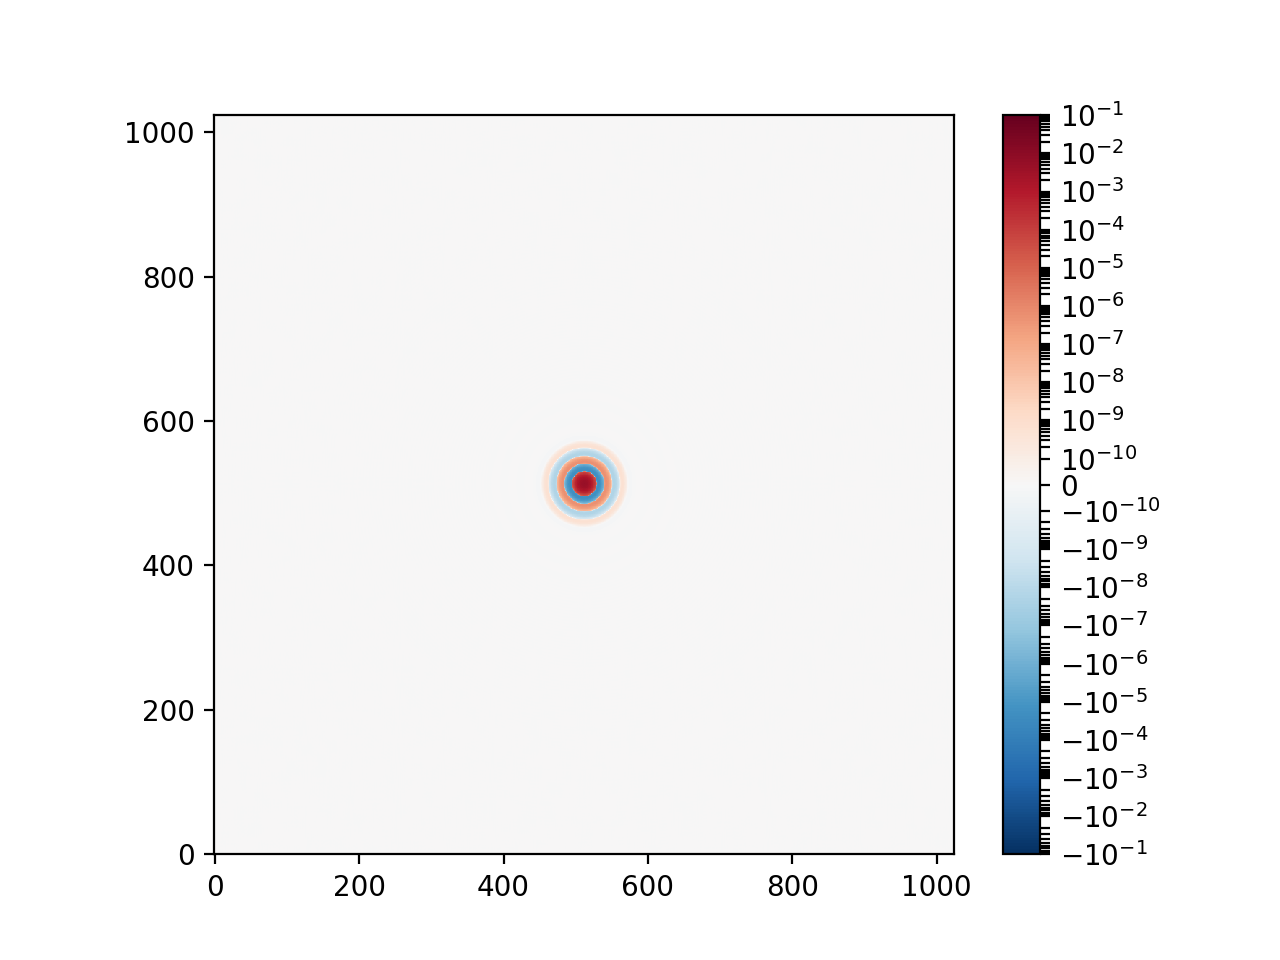

In [31]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(Pd, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-10,vmin=-0.1,vmax=0.1))
fig.colorbar(cs)

In [256]:
print(estimateFourCornerSize(Pd, p=0.999))
print(estimateFourCornerSize(Ps, p=0.999))

(array([13, 12, 12, 13]), array([13, 13, 12, 12]))
(array([20, 19, 19, 20]), array([20, 20, 19, 19]))


### See what happens to Pd if there is saturation in a source

In [143]:
rv1 = scipy.stats.multivariate_normal([0.,0.],[[3.3*3.3,0],[0,3.3*3.3]])
psf1 = rv1.pdf(coord)
m = np.amax(psf1) * 0.5
psf1[psf1> m] = m
psf1 /= np.sum(psf1)
Ppsf1 = task.padCenterOriginArray(psf1,(1024,1024))
fPpsf1 = np.fft.fft2(Ppsf1)

In [144]:
fPd = fPpsf1 * fc1

In [145]:
Pd = np.real(np.fft.ifft2(fPd))

<IPython.core.display.Javascript object>


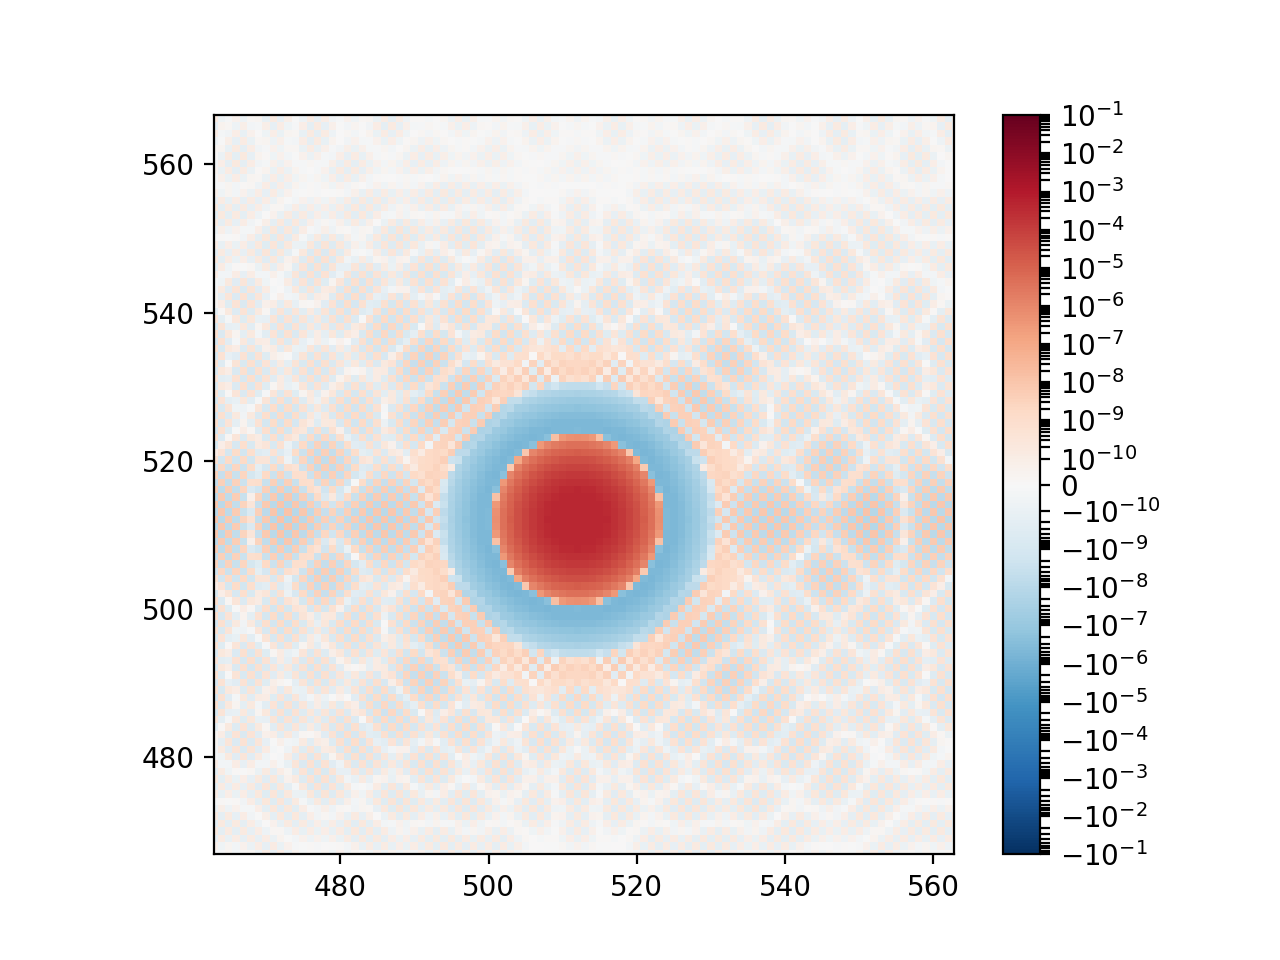

In [146]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(Pd, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-10,vmin=-0.1,vmax=0.1))
fig.colorbar(cs)

### See what happens to Pd if there is "square" source in the image

In [133]:
psf1 = np.ones((10,10))
psf1 /= np.sum(psf1)
Ppsf1 = task.padCenterOriginArray(psf1,(1024,1024))
fPpsf1 = np.fft.fft2(Ppsf1)

In [134]:
fPd = fPpsf1 * fc1

In [135]:
Pd = np.real(np.fft.ifft2(fPd))
Pd /= np.sum(Pd)

<IPython.core.display.Javascript object>


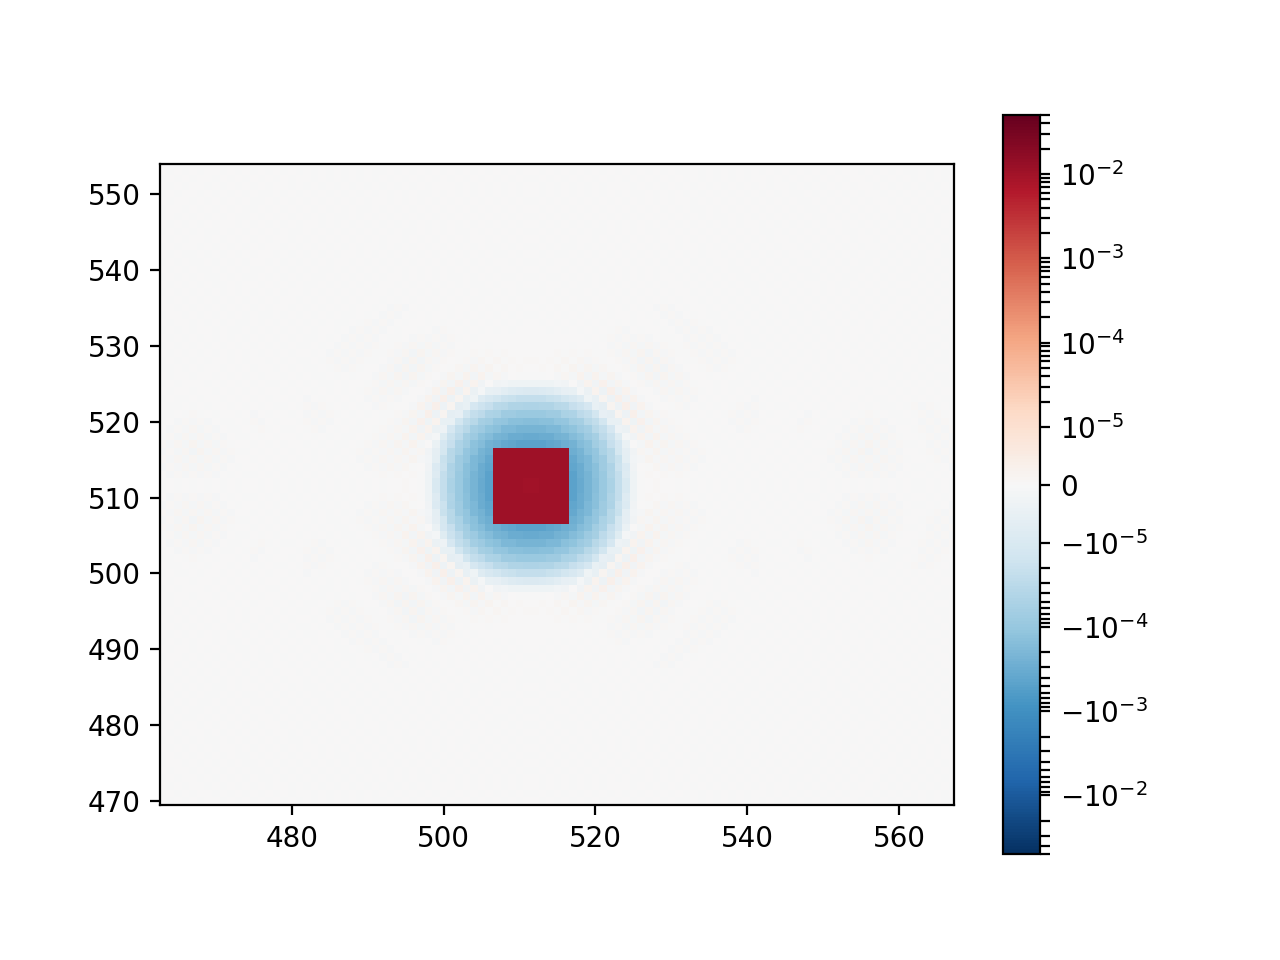

In [138]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(Pd, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-5,vmin=-0.05,vmax=0.05))
fig.colorbar(cs)

### Identical PSFs

In [101]:
# Very well sampled
x, y = np.meshgrid(np.arange(-80,81),np.arange(-80,81))
# Cut off at ~3 sigma
#x, y = np.meshgrid(np.arange(-12,13),np.arange(-12,13))
coord = np.stack((x,y), axis=-1)
print(x.shape, c.shape)

(161, 161) (25, 25, 2)


In [102]:
rv1 = scipy.stats.multivariate_normal([0.,0.],[[4.*4.,0],[0,4.*4.]])
psf1 = rv1.pdf(coord)
Ppsf1 = task.padCenterOriginArray(psf1,(1024,1024))
fPpsf1 = np.fft.fft2(Ppsf1)
print(np.sum(fPpsf1==0))
# rv2 = scipy.stats.multivariate_normal([0.,0.],[[2.2*2.2,0],[0,2.2*2.2]])
# psf2 = rv2.pdf(coord)
psf2 = psf1
Ppsf2 = task.padCenterOriginArray(psf2,(1024,1024))
fPpsf2 = np.fft.fft2(Ppsf2)

11061


In [103]:
fPd, fc1, fsc1, _ = calculatePd(fPpsf1,100,fPpsf2,100)

Handling 11061 both PSFs are zero points.


In [104]:
Pd = np.real(np.fft.ifft2(fPd))
c1 = np.real(np.fft.ifft2(fc1))
sc1 = np.real(np.fft.ifft2(fsc1))
Ps = np.real(np.fft.ifft2(np.conj(fPd)*fPd))

<IPython.core.display.Javascript object>


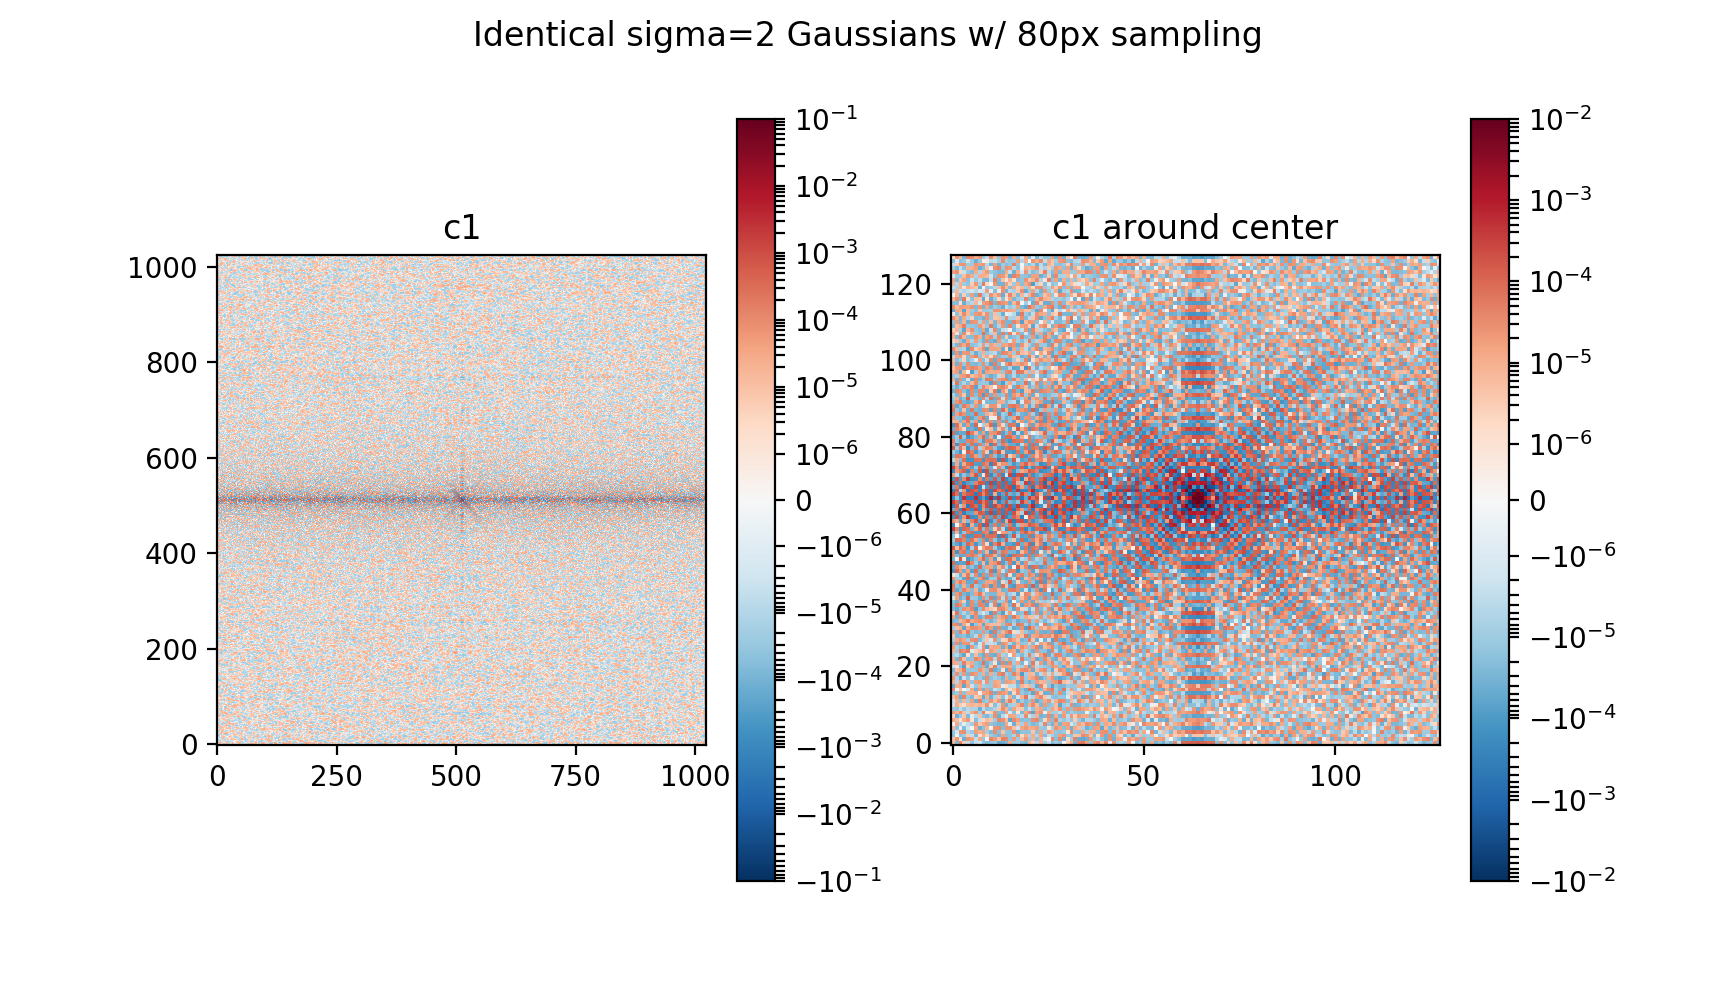

Text(0.5, 0.98, 'Identical sigma=2 Gaussians w/ 80px sampling')

In [105]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
P2 = task.padCenterOriginArray(c1, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.1,vmax=0.1))
fig.colorbar(cs)
ax.set_title("c1")

ax = fig.add_subplot(1, 2, 2)
P2 = task.padCenterOriginArray(c1, (1024,1024), useInverse=True)
cs = ax.imshow(P2[448:576, 448:576], interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.01,vmax=0.01))
fig.colorbar(cs)
ax.set_title("c1 around center")
fig.suptitle("Identical sigma=2 Gaussians w/ 80px sampling")

In [106]:
fig.savefig("id_Gauss_c1_no_cut_high_sampl_1024.pdf")

<IPython.core.display.Javascript object>


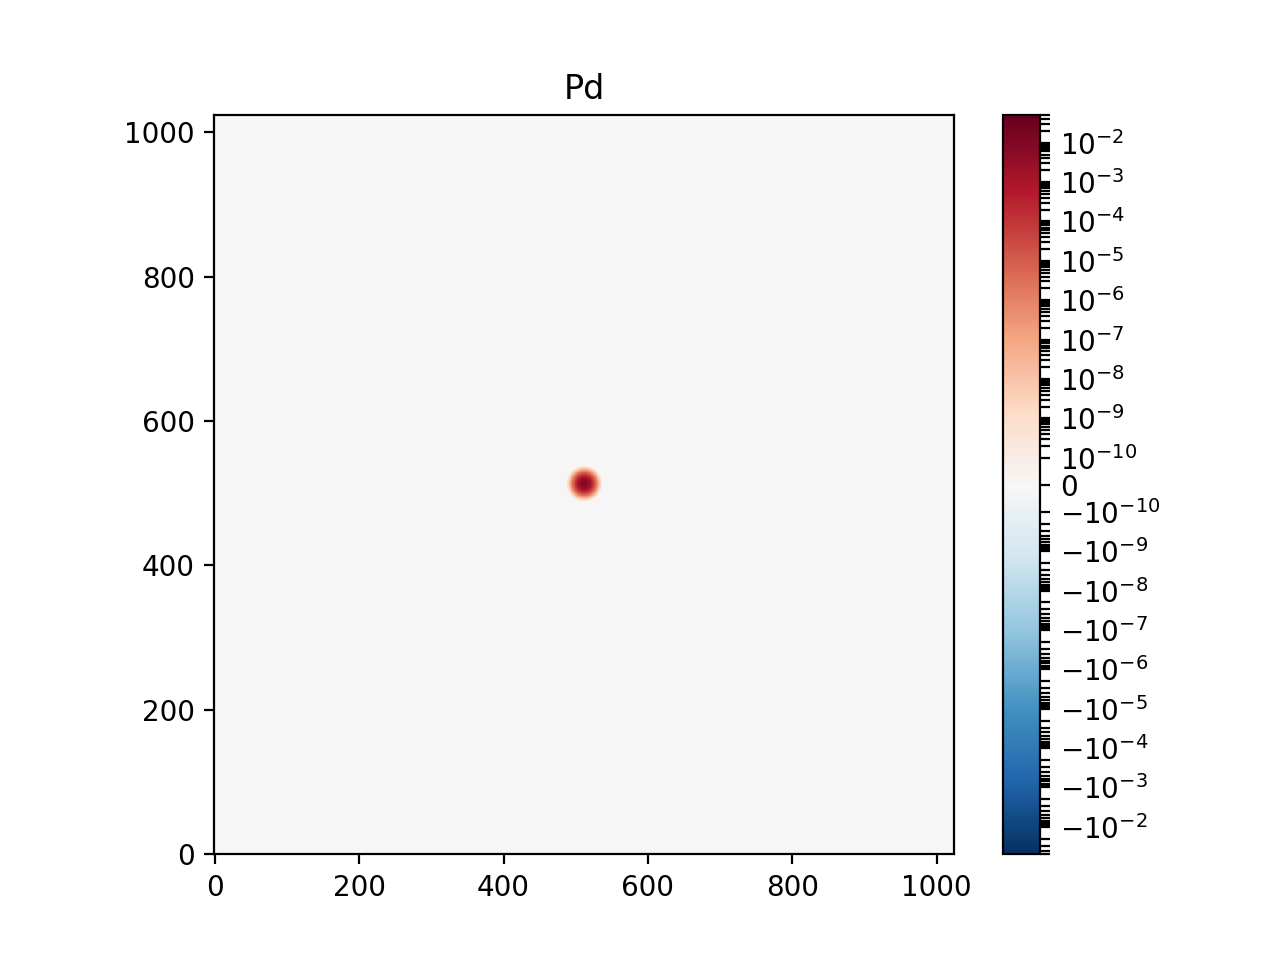

Text(0.5, 1.0, 'Pd')

In [107]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(Pd, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-10,vmin=-0.05,vmax=0.05))
fig.colorbar(cs)
ax.set_title("Pd")

### Identical PSFs w/ thresh cut

In [109]:
thresh = np.finfo(float).eps

In [110]:
rv1 = scipy.stats.multivariate_normal([0.,0.],[[4.*4.,0],[0,4.*4.]])
psf1 = rv1.pdf(coord)
Ppsf1 = task.padCenterOriginArray(psf1,(1024,1024))
fPpsf1 = np.fft.fft2(Ppsf1)
fPpsf1 [np.abs(fPpsf1) < thresh ] = 0.
print(np.sum(fPpsf1==0))
# rv2 = scipy.stats.multivariate_normal([0.,0.],[[2.2*2.2,0],[0,2.2*2.2]])
# psf2 = rv2.pdf(coord)
psf2 = psf1
Ppsf2 = task.padCenterOriginArray(psf2,(1024,1024))
fPpsf2 = np.fft.fft2(Ppsf2)
fPpsf2 [np.abs(fPpsf2) < thresh ] = 0.



672393


In [111]:
fPd, fc1, fsc1, _ = calculatePd(fPpsf1,100,fPpsf2,100)

Handling 672393 both PSFs are zero points.


In [112]:
Pd = np.real(np.fft.ifft2(fPd))
c1 = np.real(np.fft.ifft2(fc1))
sc1 = np.real(np.fft.ifft2(fsc1))
Ps = np.real(np.fft.ifft2(np.conj(fPd)*fPd))

<IPython.core.display.Javascript object>


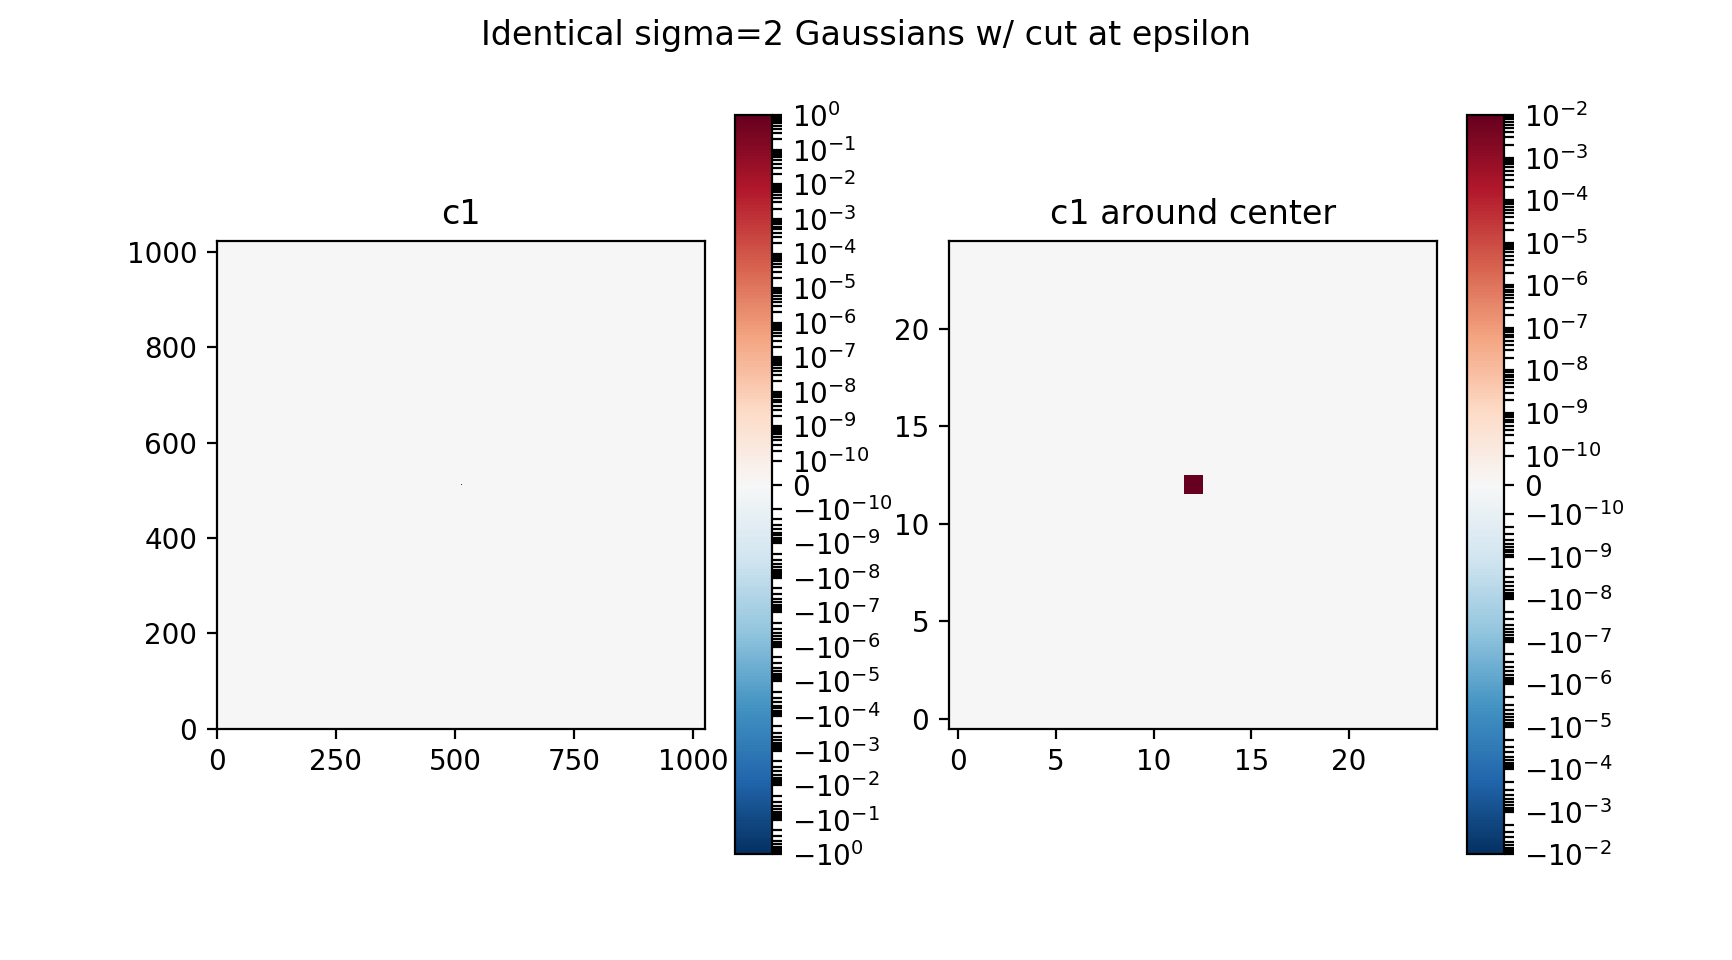

Text(0.5, 0.98, 'Identical sigma=2 Gaussians w/ cut at epsilon')

In [113]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
P2 = task.padCenterOriginArray(c1, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-10,vmin=-1.,vmax=1.))
fig.colorbar(cs)
ax.set_title("c1")

ax = fig.add_subplot(1, 2, 2)
P2 = task.padCenterOriginArray(c1, (1024,1024), useInverse=True)
cs = ax.imshow(P2[500:525, 500:525], interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-10,vmin=-0.01,vmax=0.01))
fig.colorbar(cs)
ax.set_title("c1 around center")
fig.suptitle("Identical sigma=2 Gaussians w/ cut at epsilon")

In [114]:
fig.savefig("id_Gauss_c1_eps_cut_1024.pdf")

<IPython.core.display.Javascript object>


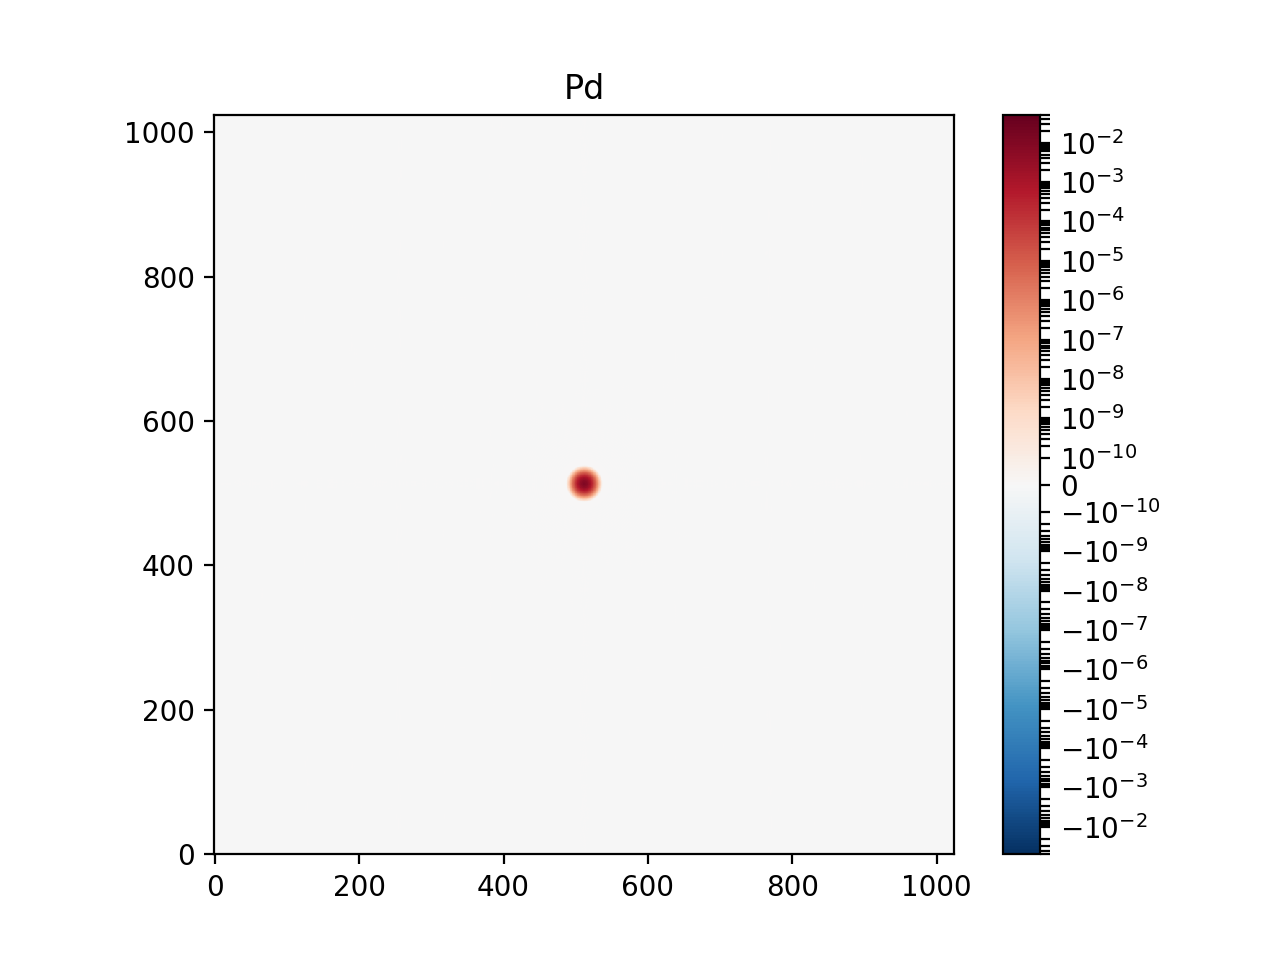

Text(0.5, 1.0, 'Pd')

In [117]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(Pd, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='lower', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-10,vmin=-0.05,vmax=0.05))
fig.colorbar(cs)
ax.set_title("Pd")

In [118]:
fig.savefig("id_Gauss_Pd_eps_cut_high_sampl_1024.pdf")